## **Prédiction de revenus**

In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms

from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
from statsmodels.stats.stattools import durbin_watson
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  StandardScaler

import datetime as dt
import math
import timeit
import random

In [2]:
# background des graphes: check
plt.style.use('bmh')
mpl.rcParams['axes.edgecolor'] = 'lightslategray'
mpl.rcParams['figure.facecolor'] = 'lightgrey'

### **Table des matières**  
  
[**1. Mission 1: préparation des données**](#1-mission-1-préparation-des-données)  
- [**1.1 Data_income - les revenus**](#11-dataincome)  
    Réponses r1.1 et r1.2
- [**1.2 Data_pop - la population**](#12-datapop)  
- [**1.3 Indice_Gini**](#13-indicegini)
  
[**2. Mission 2: étude succincte d'un échantillon**](#mission-2-étude-succincte-dun-échantillontable-des-matières)  
- [**2.1 Échantillonnage**](#21-echantillonnage)  
- [**2.2 Information: première pression à froid**](#22-informations--première-extraction-à-froid)  
    r2.1 et r2.2
  
[**3. Mission 3: le modèle**](#3-mission-3-construction-du-modèle)  
- [**3.1 Bases du modèle: lien entre les revenus parent-enfant**](#31-bases-du-modèle-lien-entre-les-revenus-parentenfant)  
    r3.1, r3.2 et r3.3
- [**3.2 Corps du modèle: classes de revenus parent/enfant**](#32-corps-du-modèle-classes-de-revenus-parentenfant)  
    Réponse r3.4
- [**3.3 Paramètre du modèle: probabilité de la mobilité des revenus**](#33-paramètre-du-modèle-probabilité-de-la-mobilité-des-revenus)   
    r3.5, r3.6 et r3.7
- [**3.4 Modèle et réalité: les classes de revenus**](#34-modèle-et-réalité-les-classes-de-revenus)  
    - 3.4.1 Préparation des individus  
    - 3.4.2 Probabilités réelles  
    - 3.4.3 Vernissage des données

  
[**4. Mission 4: compréhension du modèle**](#4-mission-4-compréhension-du-modèle)  
- [**4.1 ANOVA**](#41-anova)  
- [**4.2 Régression linéaire**](#42-régression-linéaire)  
    - 4.2.1 1ère étape: deux variables explicatives  
    - 4.2.2 2ème étape: test à trois facteurs

#### [**1. Mission 1: préparation des données**](#table-des-matières)  
  
Dans cette première partie, nous découvrons et travaillons sur les structures des données.  
Ces dernières sont réparties dans 3 sets: l'un possède des données nationales sur les revenus en fonction des pays de la clientèle, les deux autres contiennent des données sur la population et les indices de Gini de tous les pays de la planète. Nous commençons par étudier l'aspect des dataframes un à un, vérifions si des nettoyages et des sélections (années, etc) sont nécessaires. Enfin, nous réunissons tous les sets en un unique dataframe en effectuant une jointure dont les index s'appuieront sur ceux du premier jeu afin de se restreindre aux pays des prospects.

In [3]:
data_income = pd.read_csv('data_income.csv', decimal = ',')
data_pop = pd.read_csv('population.csv', skiprows = [0, 2])
indice_gini = pd.read_csv('data_gini.csv', skiprows = [0, 2])

In [4]:
data_pop.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,...,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106445.0,NaN


##### [**1.1 Data_income**](#table-des-matières)  
  
Dataframe des pays de prospects.

In [5]:
# taille et nom des colonnes
data_income.shape, data_income.head(1)

((11599, 6),
   country  year_survey  quantile  nb_quantiles     income  gdpppp
 0     ALB         2008         1           100  728.89795  7297.0)

In [6]:
data_income.dtypes

country          object
year_survey       int64
quantile          int64
nb_quantiles      int64
income          float64
gdpppp          float64
dtype: object

Nombre d'individus important, toutes les valeurs des colonnes sont pertinentes, nom des pays codé, certainement présentent de valeurs NaN.  
Besoins:  
- retrouver le codage des pays;  
- avoir un aperçu des années et des unités.

In [7]:
# aperçu des années et des unités
data_income.year_survey.unique()

array([2008, 2009, 2010, 2007, 2006, 2011, 2004], dtype=int64)

Les unités sont en PPA, autrement, les conventions utilisées varient en fonction des années et des régions donc, pour l'instant, nous les laissons telles quelles. Un compte en banque étant considéré inactif au bout de an, 5 pour les comptes épargnes, nous ne retenons pas les dates antérieures à 5 ans.  
Nous récupérons logiquement les 5 années les plus récentes, vérifions les nouvelles quantités d'individus puis passons au nettoyage.  
NB: le codage de pays sera récupéré avec le deuxième dataset.

In [8]:
# sélection des données d'au plus 5 ans
data_revenu = data_income[data_income.year_survey > 2006].copy()

In [9]:
# révision sur la taille de l'échantillon
data_revenu.shape

(10999, 6)

In [10]:
# nombre de pays prospectés
len(data_revenu.country.unique())

110

Les clients actifs de la banque sont répartis dans 110 pays. Le nombre d'individus reste suffisamment important pour permettre une exploitation intéressante. Nous passons au pré-nettoyage.

In [11]:
# présence de valeurs NaN?
data_revenu.isna().any()

country         False
year_survey     False
quantile        False
nb_quantiles    False
income          False
gdpppp           True
dtype: bool

Nous avons des valeurs manquantes dans la colonne des unités. Le but va être de récupérer les pays aux valeurs NaN puis de retrouver leur unités dans le df principal. Si ces valeurs sont toujours manquantes, nous attendrons la jointure de deux df afin de récupérer le nom de ces pays et donc leur régions du globe afin de savoir quelle convention est utilisée pour le calcul de leur pouvoir d'achat.

In [12]:
# récupération des individus et des index aux valeurs NaN
ind_nan = data_revenu[data_revenu.gdpppp.isna()]
idx_nan = data_revenu[data_revenu.gdpppp.isna()].index

In [13]:
# nom des pays aux unités manquantes
ind_nan.country.unique()

array(['XKX', 'PSE'], dtype=object)

In [14]:
# vérification des autres unités dans le df principale
data_income[(data_income.country == 'XKX') | (data_income.country == 'PSE')].gdpppp.unique()

array([nan])

Toutes les unités des deux pays aux gdpppp NaN sont manquantes. Nous finirons le nettoyage à la jointure. Nous passons au nettoyage significatif des données.

In [15]:
data_revenu.dtypes

country          object
year_survey       int64
quantile          int64
nb_quantiles      int64
income          float64
gdpppp          float64
dtype: object

Nous vérifions le code des pays commençant par la lettre N. Les valeurs des autres colonnes ont un format adéquat.

In [16]:
# valeurs NaN de la colonne des codes pays
data_revenu[(data_revenu.country > 'N') & (data_revenu.country < 'NZ')].country.unique()

array(['NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL'], dtype=object)

Les types sont conforment à leur paramètres respectifs et il n'y a aucune valeur manquante dans le codage des pays. Nous changeons le nom de quelques colonnes et effectuons un aperçu des valeurs présentes dans le set.

In [17]:
# changement de nom de colonne
data_revenu.rename(columns = {
    'country':'code',
    'year_survey':'year'
    }, inplace = True)

In [18]:
# colonne nb_quantiles
data_revenu.nb_quantiles.unique()

array([100], dtype=int64)

###### <span style="color:green">[r1.1]  
La colonne ne présente qu'un seul type de quantiles, le 100 autrement dit, les revenus sont tous répartis par quantile et avons donc 100 classes de revenus par pays.

###### <span style="color:green">[r1.2]  
Échantillonner la population d'un pays à l'aide de quantile va nous permettre d'un côté, de réduire le traitement en n'ayant pas à analyser chaque valeur de revenus et de l'autre, de regrouper les ménages par rendement financier significatif.

##### [**1.2 Data_pop**](#table-des-matières)

In [19]:
data_income.head(1)

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0


In [20]:
# aperçu du df sur la population
data_pop.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,...,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106445.0,NaN


L'étendue des dates est de plusieurs décénnies et nous retrouvons les noms entiers de pays ainsi que leur code. De toutes les années, nous ne conservons que celles remontant aux 5 dernières années.

In [21]:
# récupération des intitulés de pays et des 5 années retenues
bdd_pop = data_pop.loc[:, ['Country Name', 'Country Code', '2007', '2008', '2009', '2010', '2011']]

Prochaines actions:   
- renommage des noms de colonnes;  
- vérification des doublons;  
- nettoyage des valeurs Nan et des valeurs non-significatives;  
- jointure au df des revenus sous le df 'Bdd';  
- récupération des unités manquantes en récupérant les noms et donc les régions des conventions PPA.

In [22]:
# renommage des colonnes
bdd_pop.columns = ['pays', 'code', 2007, 2008, 2009, 2010, 2011]

In [23]:
# présence de doublons?
bdd_pop.shape, bdd_pop.drop_duplicates(['pays', 'code']).shape

((266, 7), (266, 7))

In [24]:
# présence de valeurs NaN?
bdd_pop.isna().any()

pays     True
code    False
2007     True
2008     True
2009     True
2010     True
2011     True
dtype: bool

Nous commençons par les noms de pays.

In [25]:
# individus sans noms de pays
bdd_pop[bdd_pop.pays.isna()]

,pays,code,2007,2008,2009,2010,2011
1,NaN,AFE,482406426.0,495748900.0,509410477.0,523459657.0,537792950.0
3,NaN,AFW,327612838.0,336893835.0,346475221.0,356337762.0,366489204.0


Nous n'avons pas de doublons donc nous ne pouvons pas récupérer le nom des pays sur d'autres individus. Nous les sauvegardons et, lors de l'analyse univarié des classes des revenus, puisque nous visons les catégories socio-professionnelles élevés, nous verrons si ces deux pays sont intéressants à conserver.

In [26]:
# sauvegarde des pays sans nom
pays_ss_nom = bdd_pop[bdd_pop.pays.isna()]

In [27]:
# valeurs NaN dans la première colonne d'année
bdd_pop[bdd_pop[2007].isna()]

,pays,code,2007,2008,2009,2010,2011
110,Non classifié,INX,NaN,NaN,NaN,NaN,NaN


In [28]:
# correspondance de ce code dans le df des revenus?
data_revenu[data_revenu.code == 'INX']

,code,year,quantile,nb_quantiles,income,gdpppp


La référence n'est pas répertoriée => suppression de l'index.

In [29]:
# suppression d'index NaN
bdd_pop.drop(110, inplace = True)

In [30]:
# re-vérification des valeurs NaN
bdd_pop.isna().any()

pays     True
code    False
2007    False
2008    False
2009    False
2010    False
2011    False
dtype: bool

Excepté les deux pays sans nomination, le df est propre.  
Nous assemblons les deux sets dans un nouveau dataframe BDD. La fusion se fait année par année sur les deux dfs indexés par 'code pays' pour faciliter les affectations de valeurs qui sont placées sous la colonne 'population' de 'BDD'.

In [31]:
# initialisation de BDD + ajout de la colonne 'population'
bdd = data_revenu.set_index('code')
bdd['population'] = 0

In [32]:
# ajout des valeurs de BDD en fonction des codes et années dans la colonne 'population'
for annee in bdd_pop.columns[2:]: # toutes les colonnes années
    ech_annee = bdd_pop[['code', annee]]
    ech_indexe = ech_annee.rename(columns = {annee:'population'})
    bdd.loc[bdd.year == annee, 'population'] = ech_indexe.set_index('code')

In [33]:
# à part les 2 codes sans unités PPA, présence de NaN?
bdd.isna().any()

year            False
quantile        False
nb_quantiles    False
income          False
gdpppp           True
population       True
dtype: bool

In [34]:
# index des individus à la population manquante
bdd[bdd.population.isna()].index.unique()

Index(['TWN'], dtype='object', name='code')

In [35]:
# vérification des données dans la dataframe population
bdd_pop[bdd_pop.code == 'TWN']

,pays,code,2007,2008,2009,2010,2011


Il nous manque les données de l'individu 'TWN' or cette préparation de données commence à prendre trop de temps et ne fait pas parti des points névralgiques de ce projet => suppression de 'TWN'.

In [36]:
bdd.drop('TWN', inplace = True)

##### [**1.3 Indice_gini**](#table-des-matières)

In [37]:
# taille et noms de colonnes du df
indice_gini.shape, indice_gini.columns

((266, 67),
 Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
        '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
        '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
        '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
        '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
        '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
        '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
        '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
        'Unnamed: 66'],
       dtype='object'))

In [38]:
# présence de doublons?
indice_gini.drop_duplicates('Country Code').shape

(266, 67)

Nous devons également sélectionner les 5 en question. L'indice de Gini étant une données statistique relativement complexe, nous nous attendons à ce qu'il y ait beaucoup de valeurs manquantes particulièrement concernant les pays de régions en développement.  
Nombre de lignes après 'drop_duplicates' identiques au format brut => pas de doublons.

In [39]:
gini = indice_gini[['Country Name', 'Country Code', '2007', '2008', '2009', '2010', '2011']].copy()

In [40]:
# renommage des colonnes
gini.rename(columns = {
    'Country Name':'pays',
    'Country Code':'code'},
    inplace = True)

In [41]:
# copie des noms de pays de gini dans BDD
indexe = gini.set_index('code')
bdd.insert(0, 'pays', indexe.pays)

In [42]:
# extraction des pays des prospects + taille du df
gini = gini[gini.code.isin(data_revenu.code)]
gini.shape

(109, 7)

In [43]:
# nombre d'individus ayant des indices de Gini manquants
len(gini[gini.isna()])

109

Tous les pays ont des données manquantes donc plutôt que de chercher à les traiter ou rechercher une autre source potentiellement "trouée", nous décidons de tous les calculer/recalculer. Nous utilisons un df indexé afin de faciliter l'affectation des valeurs.

In [44]:
# réindexation de BDD
bdd.reset_index(inplace = True)
bdd.set_index(['code', 'year'], inplace = True)

In [ ]:
# calcul de l'indice de Gini par pays et par année

n = 100 # taille standard de tous les couples [pays, année] (revenu/quantile)
for code, annee in bdd.index.unique():
    data = bdd.loc[(code, annee), 'income'].values
    
# calcul de la courbe de Lorenz
    lorenz = np.cumsum(np.sort(data)) / data.sum()
    lorenz = np.append([0], lorenz)

# calcul de l'indice de Gini
    auc = (lorenz.sum() - lorenz[-1]/2 - lorenz[0]/2) / n
    s = 0.5 - auc
    gini = 2 * s
    bdd.loc[(code, annee), 'gini'] = round(gini * 100, 2) # indice en % avec 2 décimales

In [46]:
# valeurs NaN, valeurs non significatives?
bdd.isna().any(), bdd.dtypes

(pays            False
 quantile        False
 nb_quantiles    False
 income          False
 gdpppp           True
 population      False
 gini            False
 dtype: bool,
 pays             object
 quantile          int64
 nb_quantiles      int64
 income          float64
 gdpppp          float64
 population      float64
 gini            float64
 dtype: object)

#### [**Mission 2: étude succincte d'un échantillon**](#table-des-matières)  
  
Le dataframe principale, BDD, réunit les données sur les revenus par pays de prospects, leur population respective et l'indice de Gini de leurs classes de revenus. Dans cette deuxième partie, nous extrayons des informations de BDD: il s'agit d'avoir un aperçu des comportements des pays en fonction des aspects socio-économiques retenus.  
Nous ne travaillons pas sur l'ensemble des données mais sur un échantillon donc nous sélectionnons un groupe représentatif de pays.  
   
Les étapes:  
- préparation de l'échantillon;  
- étude N°1 des informations : les revenus;  
- étude N°2 des informations : la courbe de Lorenz;  
- étude N°3 des informations : indice de Gini.

##### [**2.1 Echantillonnage**](#table-des-matières)  
  
Selon la logique de la problématique, nous choisissons le paramètre 'revenu' pour orienter la construction de l'échantillon. Nous regardons comment se comportent ses valeurs, définissons et appliquons les règles de sélection pour la constitution du groupe d'étude.  
Pour les comparaisons, nous nous appuyons sur le dernier quantile.

In [47]:
# sélection des individus au 100ème quantile
bdd_ = bdd[bdd['quantile'] == 100].copy()

In [48]:
# réinitialisation des index dû au df BDD
bdd_.reset_index(level = 1, inplace = True)
bdd_.shape

(109, 8)

In [49]:
# mesures de position et de dispersion de la colonne 'income'
mesure = bdd_.income.describe()
mesure

count       109.000000
mean      38608.790797
std       38145.627807
min        2022.775900
25%        8973.289000
50%       26059.270000
75%       55466.152000
max      176928.550000
Name: income, dtype: float64

Nous utilisons les quartiles de la distribution afin de définir des classes de valeurs équitablement réparties au sein de la population et sélectionnons deux individus par quartile à l'aide de random.choices (pseudo-hasard).

In [50]:
# initialisation
echantillon_ = pd.DataFrame()

In [ ]:
# construction de l'échantillon
for i in range(3, 7, 1): # parcours des valeurs de 'mesure' de position de bdd_
    individus = bdd_[(mesure[i] < bdd_.income) & (bdd_.income < mesure[i + 1])].index
    choix = random.choices(individus, k = 2) # choix de 2 individus
    echantillon_ = pd.concat([echantillon_, bdd_.loc[choix, :]])

Nous venons de sélectionner 8 pays représentatifs de BDD: le squelette de l'échantillon est fait. Maintenant, il nous faut récupérer tous les quantiles de revenus de ces individus afin d'avoir l'ensemble des classes de revenus par pays.

In [52]:
# pour faciliter la recherche de la prochaine cellule
bdd.reset_index(inplace = True)
echantillon_.reset_index(inplace = True)

In [53]:
# copie de tous les quantiles de BDD dans 'Echantillon'
echantillon = pd.concat([echantillon_, bdd[bdd.code.isin(echantillon_.code)]])
echantillon.drop_duplicates(inplace = True)

In [54]:
# sauvegarde d'un echantilllon intéressant
liste_code = ['MLI', 'BGD', 'TJK', 'MWI', 'POL', 'MKD', 'IRL', 'BRA']
echantillon_ex = bdd[bdd.code.isin(liste_code)]

L'échantillon est prêt. Avant de passer à l'étude des paramètres statistiques, rappelons-nous que nous avions eu, lors du nettoyage, des individus dans unités PPA et sans noms usuels. Nous devions vérifier leur intérêt en analysant la position de leur revenus sur l'échelle totale des revenus mais vu le temps de traitement et la quantité d'individus, remplacer les données manquantes "à la main" est faisable.  
La banque de données utilise les codes ISO 3166-3 $\alpha$ or le site des ISO ne reconnaît pas AFE et AFW => suppression.  
Concernant les pays sans unités PPA, il s'agit de régions économiquement faibles: si les unités PPA doivent avoir un rôle pertinent, nous aviserons.  
  
  
##### [**2.2 Informations : première extraction à froid**](#table-des-matières)
  
Nous faisons une étude comportementale des individus et de leur valeurs concernant le revenu moyen et l'indice de Gini de l'échantillon 'Echantillon'.

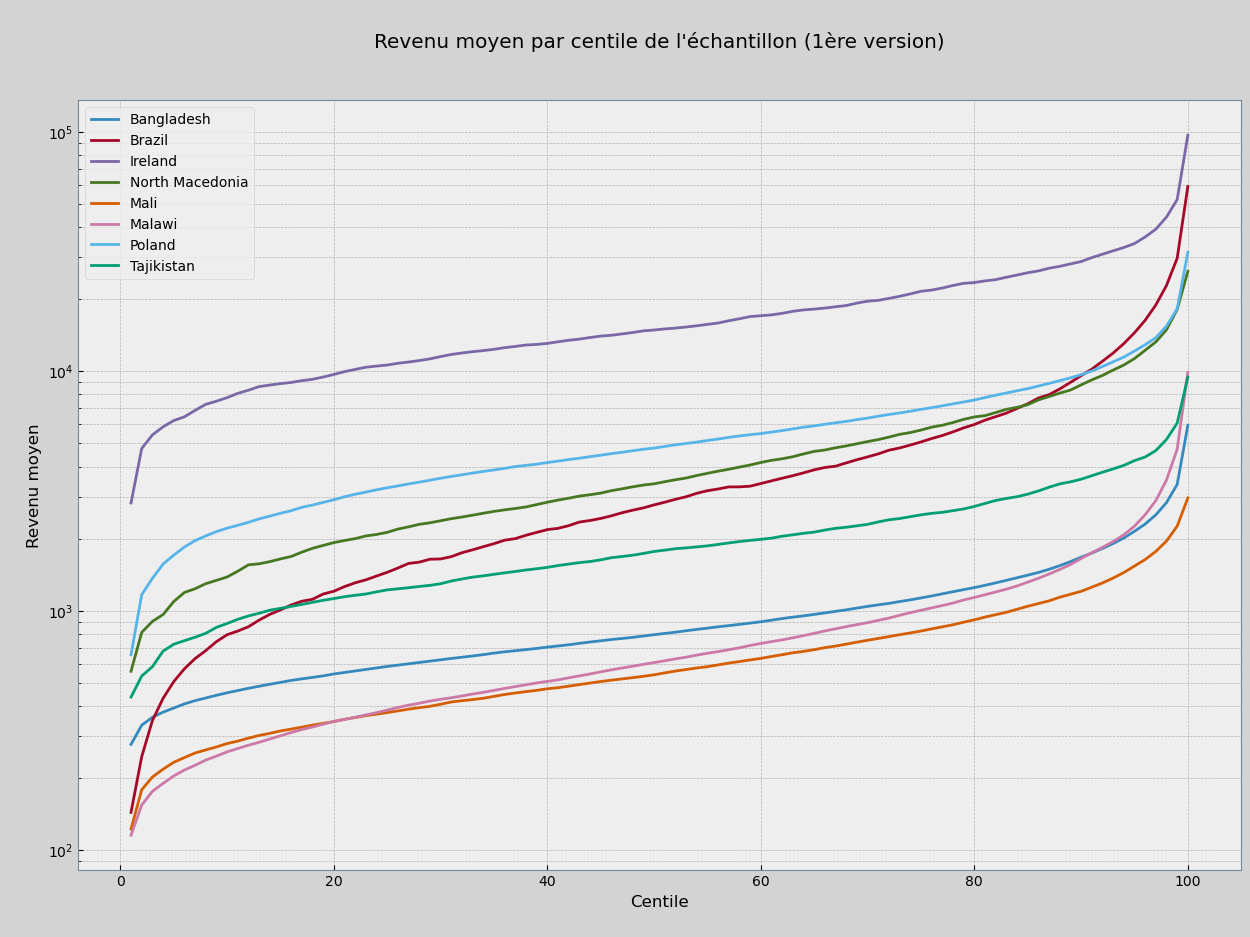

In [55]:
# représentation logarithmique des revenus
plt.figure(figsize = (15, 10))

for pays in echantillon_ex.pays.unique():
    x = echantillon_ex[echantillon_ex.pays == pays]['quantile'].sort_values()
    y = echantillon_ex[echantillon_ex.pays == pays].income.sort_values()

    plt.plot(x, y)
    plt.yscale('log')
    plt.grid(True, which = 'both')
    

plt.legend(echantillon_ex.pays.unique())

plt.xlabel("Centile\n")
plt.ylabel("\nRevenu moyen")
plt.title("\nRevenu moyen par centile de l'échantillon (1ère version)\n\n")
plt.show()

Nous avons 3 profils:  
- le premier regroupe des individus à fort revenus moyens caractérisant les pays dits développés;  
- le deuxième profil caractérise les pays à bas faible revenus moyens et dont les quantiles supérieurs sont de l'ordre de grandeur des quantiles inférieurs du 1er profil;
- le troisième cas est particulier, il est illustré ici par le Brésil dont l'étendu des classes de revenus est trop important: les classes basses sont dans le minimum global alors que les forts revenus atteignent le maximum global, ici égale aux revenus maximals de l'Ireland, un paradis fiscal.  
  
Le dernier profil est une caractéristique des pays à très fortes inégalités ayant, généralement, pas ou très peu de classes moyennes;  
=> Ne peuvent répondre au même schéma statistique que la majorité des pays;  
=> Doivent être exclus de l'échantillon mais sont conservés et exploités puisque ces pays sont un terrain parfait pour une clientèle aisée et dépensière.  
  
Prochaines étapes [6] :  
- filtrer les pays à fortes inégalités sociales;  
- re-créer un échantillon d'individus "types";  
- ré-impression de la représentation des revenus moyens par quantile pour le nouvel échantillon et les "Inégalitaires";  
- courbe de Lorenz pour "Echantillon" et "Inégalitaires";  
- évolution de l'indice de Gini pour les deux profils;  
- classement de l'ensemble des pays par inégalité.

**Etape 1/6: filtrage des pays à forte inégalité**  
  
Nous avons le dataframe principal BDD dans lequel nous appliquons un boxplot à partir des indices de Gini. Nous repérons les outliers.

In [56]:
# rappel du dataframe principal
bdd.head(2)

,code,year,pays,quantile,nb_quantiles,income,gdpppp,population,gini
0,ALB,2008,Albania,1,100,728.89795,7297.0,2947314.0,30.46
1,ALB,2008,Albania,2,100,916.66235,7297.0,2947314.0,30.46


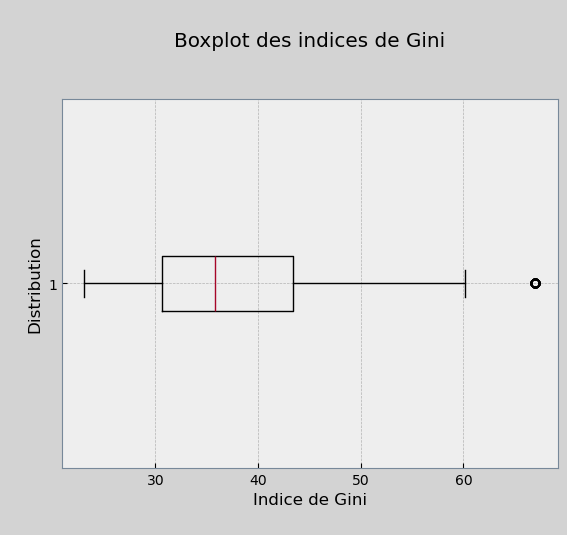

In [57]:
# boxplot sur les indices de Gini
plt.boxplot(bdd.gini, vert = False)
plt.ylabel("\nDistribution")
plt.xlabel("Indice de Gini\n")
plt.title('\nBoxplot des indices de Gini\n\n')
plt.show()

In [58]:
# nom du outlier
bdd[bdd.gini > 60].pays.unique()

array(['Honduras', 'South Africa'], dtype=object)

Le Brésil n'apparaît pas dans la liste des outliers or la première représentation des revenus par quantile montre bien que ce pays a une répartition inégalitaire importante. => l'indice de Gini n'est pas un indicateur suffisant pour caractériser les "Inégalitaires".  
=> Puisque nous possédons les classes de revenus de tous les quantiles, nous calculons un autre indicateur d'inégalité plus efficace: l'interdécile P90/P10.

In [59]:
# création d'un df contenant les indicateurs socio-économiques de BDD
bdd_ind = bdd[['code', 'pays', 'year', 'population', 'gini']]

In [60]:
# initialisation de BDD_ind(ices)
bdd_ind = bdd_ind.drop_duplicates(['code', 'year'])
bdd_ind.set_index(['code', 'year'], inplace = True)

In [61]:
# indexation de BDD pour affectation vectorielle
bdd.set_index(['code', 'year'], inplace = True)

In [62]:
# calcul de l'interdécile
interdecile = bdd[bdd['quantile'] == 90].income / bdd[bdd['quantile'] == 10].income
bdd_ind['interdecile'] = interdecile

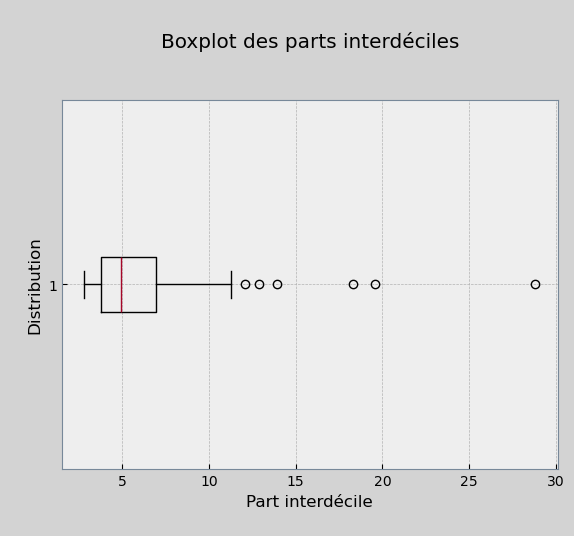

In [63]:
# boxplot des interdéciles
plt.boxplot(bdd_ind.interdecile, vert = False)
plt.xlabel("Part interdécile\n")
plt.ylabel("\nDistribution")
plt.title("\nBoxplot des parts interdéciles\n\n")
plt.show()

Nous avons 6 outliers représentant des pays à très fortes inégalités. Nous récupérons leur identités et les stockons leurs données socio-éco. dans "Inégalitaires_ind" et leurs classes de revenus sous le nom de "Inégalitaires".

In [64]:
bdd.reset_index(inplace = True)
bdd_ind.reset_index(inplace = True)

In [65]:
# changement de la "limite outlier" de 12 à 10
inegalitaires_ind = bdd_ind[bdd_ind.interdecile > 10].copy()
inegalitaires = bdd[bdd.code.isin(inegalitaires_ind.code)].copy()

In [66]:
# pays ayant les plus fortes inégalités
inegalitaires_ind

,code,year,pays,population,gini,interdecile
11,BOL,2008,Bolivia,9.880593e+06,56.15,18.286192
12,BRA,2008,Brazil,1.926723e+08,54.45,12.063036
14,CAF,2008,Central African Republic,4.467233e+06,56.17,10.812668
17,CHN,2007,China,1.317885e+09,47.83,10.645015
20,COL,2008,Colombia,4.381531e+07,56.93,13.909685
27,ECU,2008,Ecuador,1.449680e+07,50.99,10.233982
38,GTM,2011,Guatemala,1.452152e+07,56.83,11.237528
39,HND,2008,Honduras,8.101777e+06,60.17,19.552475
67,MEX,2008,Mexico,1.096845e+08,50.80,10.476643
78,NIC,2009,Nicaragua,5.770639e+06,48.28,10.619359


Nous avons bien le Brésil. Selon les résultats graphiques de l'échantillon, si nous devions retrouver le même schéma comportemental des revenus, nous pourrions être amenés à modifier la limite inégalitalire de l'interdécile.  
  
PS: Une modification a été faite pour cause d'individus supplémentaires dont les revenus présentent un schéma inégalitaire très marqué.

In [67]:
# filtrage du df principal
idx = bdd[bdd.code.isin(inegalitaires_ind)].index
bdd.drop(idx, inplace = True)

**Etape 2/6: re-création d'un échantillon d'étude**  
  
Nous avons le dataframe principal BDD. Nous rappelons les étapes de construction:  
- sélection du centième quantile pour la comparaison;  
- mesure de position et de de dispersion de la variable 'revenu';  
- création de l'échantillon selon les revenus par rapport aux quartiles des revenus.

In [68]:
# sélection des individus au 100ème quantile
bdd_ = bdd[bdd['quantile'] == 100].copy()

In [69]:
# mesures de position et de dispersion de la colonne 'income'
mesure = bdd_.income.describe()
mesure

count       109.000000
mean      38608.790797
std       38145.627807
min        2022.775900
25%        8973.289000
50%       26059.270000
75%       55466.152000
max      176928.550000
Name: income, dtype: float64

In [70]:
# initialisation
echantillon_ = pd.DataFrame()

In [71]:
# construction de l'échantillon
for i in range(3, 7, 1): # parcours des valeurs de 'mesure' de position de bdd_
    individus = bdd_[(mesure[i] < bdd_.income) & (bdd_.income < mesure[i + 1])].index
    choix = random.choices(individus, k = 2) # choix de 2 individus
    echantillon_ = pd.concat([echantillon_, bdd_.loc[choix, :]])

C:\Users\Dar_ia\AppData\Local\Temp\ipykernel_6216\2937499910.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  individus = bdd_[(mesure[i] < bdd_.income) & (bdd_.income < mesure[i + 1])].index
C:\Users\Dar_ia\AppData\Local\Temp\ipykernel_6216\2937499910.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  individus = bdd_[(mesure[i] < bdd_.income) & (bdd_.income < mesure[i + 1])].index
C:\Users\Dar_ia\AppData\Local\Temp\ipykernel_6216\2937499910.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

In [72]:
# copie de tous les quantiles de BDD dans 'Echantillon'
echantillon = pd.concat([echantillon_, bdd[bdd.code.isin(echantillon_.code)]])
echantillon.drop_duplicates(inplace = True)

**Etape 3/6: ré-impression des revenus en fonction des quantiles**  
  
Nous représentons également le revenus des "Inégalitaires".  
###### <span style="color:green">[r2.1]

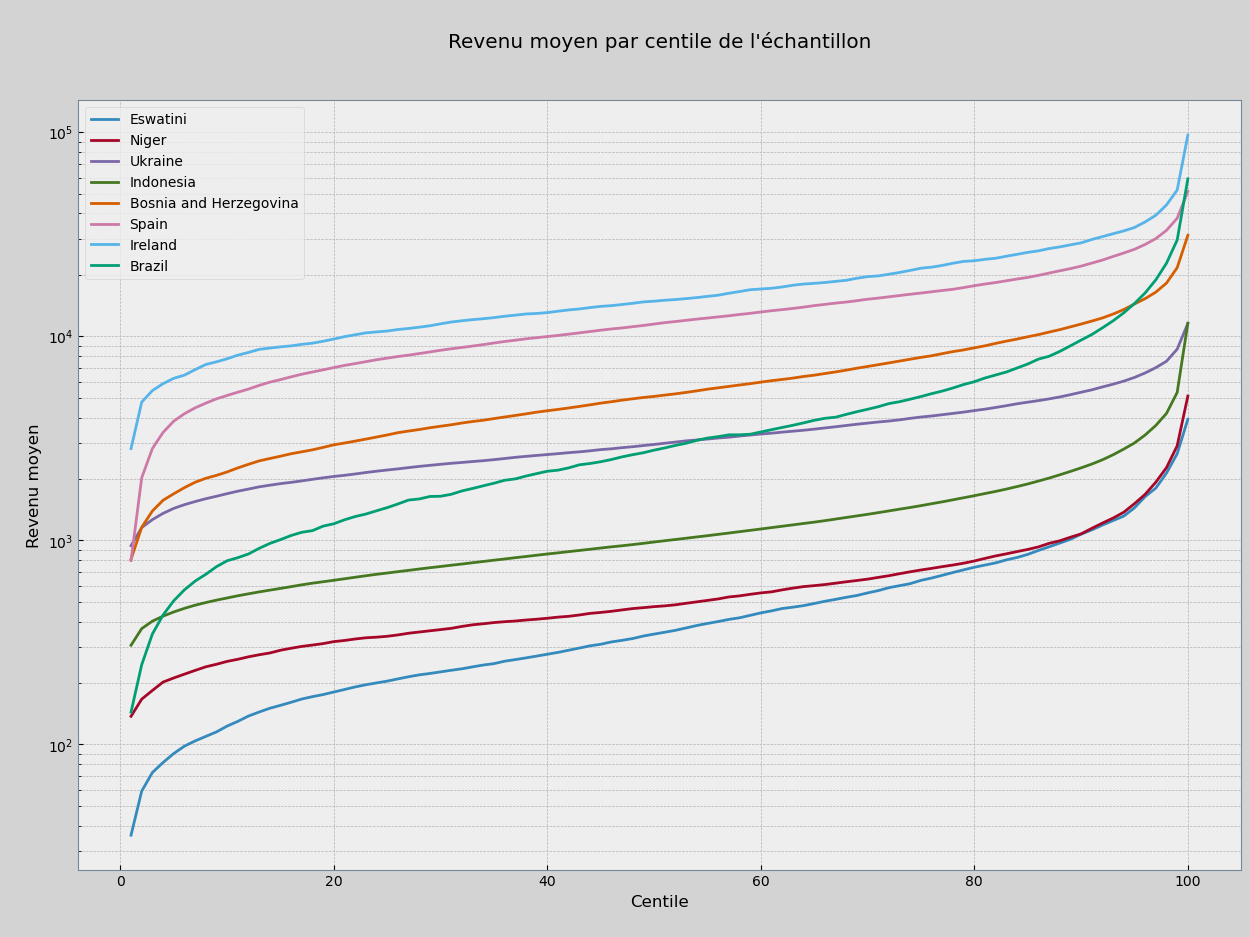

In [73]:
# représentation logarithmique des revenus
plt.figure(figsize = (15, 10))

for pays in echantillon.pays.unique():
    x = echantillon[echantillon.pays == pays]['quantile'].sort_values()
    y = echantillon[echantillon.pays == pays].income.sort_values()

    plt.plot(x, y)
    plt.yscale('log')
    plt.grid(True, which = 'both')
    

plt.legend(echantillon.pays.unique())

plt.xlabel("Centile\n")
plt.ylabel("\nRevenu moyen")
plt.title("\nRevenu moyen par centile de l'échantillon\n\n")
plt.show()

Différentes projections mettent en avant la présence d'individus dit "très inégalitaires". Nous pourrions davantage restreinte la liste des individus "classiques" mais de ce graphique, nous retenons principalement la répartition des pays en deux groupes distincts dont les revenus supérieurs de l'un correspondent, en terme d'ordre de grandeur, aux revenus inférieurs de l'autre.  
Nous passons à la représentation des revenus du groupe "Inégalitaires".

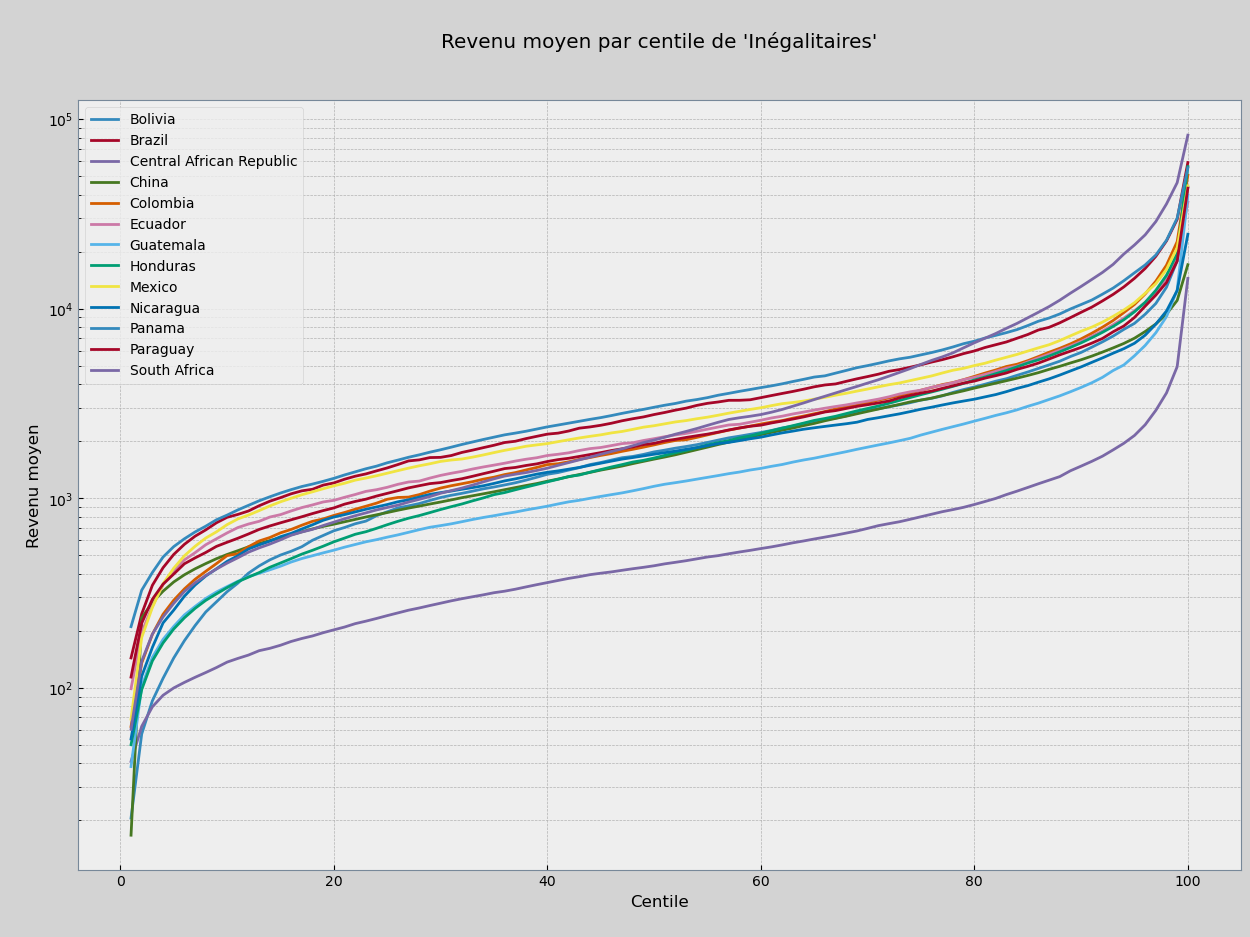

In [74]:
# représentation logarithmique des revenus des "Inégalitaires"
plt.figure(figsize = (15, 10))

for pays in inegalitaires.pays.unique():
    x = inegalitaires[inegalitaires.pays == pays]['quantile'].sort_values()
    y = inegalitaires[inegalitaires.pays == pays].income.sort_values()

    plt.plot(x, y)
    plt.yscale('log')
    plt.grid(True, which = 'both')
    

plt.legend(inegalitaires.pays.unique())

plt.xlabel("Centile\n")
plt.ylabel("\nRevenu moyen")
plt.title("\nRevenu moyen par centile de 'Inégalitaires'\n\n")
plt.show()

Les observations que nous avions faites sur les classes de revenus des "Inégalitaires" sont plus que similaires: la très faible variation entre les distributions de revenus quantile peut être vue comme une condition nécessaire et suffisante d'un climat socio-économique très inégalitaire. Remarquons le cas de l'Afrique du Sud: un outlier parmi les outliers dont le comportement de sa distribution des classes est extrême.  
Une représentation de la courbe de Lorenz de ces deux échantillons va nous permettre de mettre davantage en évidence ces inégalités.

**Etape 4/6: courbe de Lorenz**  
###### <span style="color:green">[r2.2]

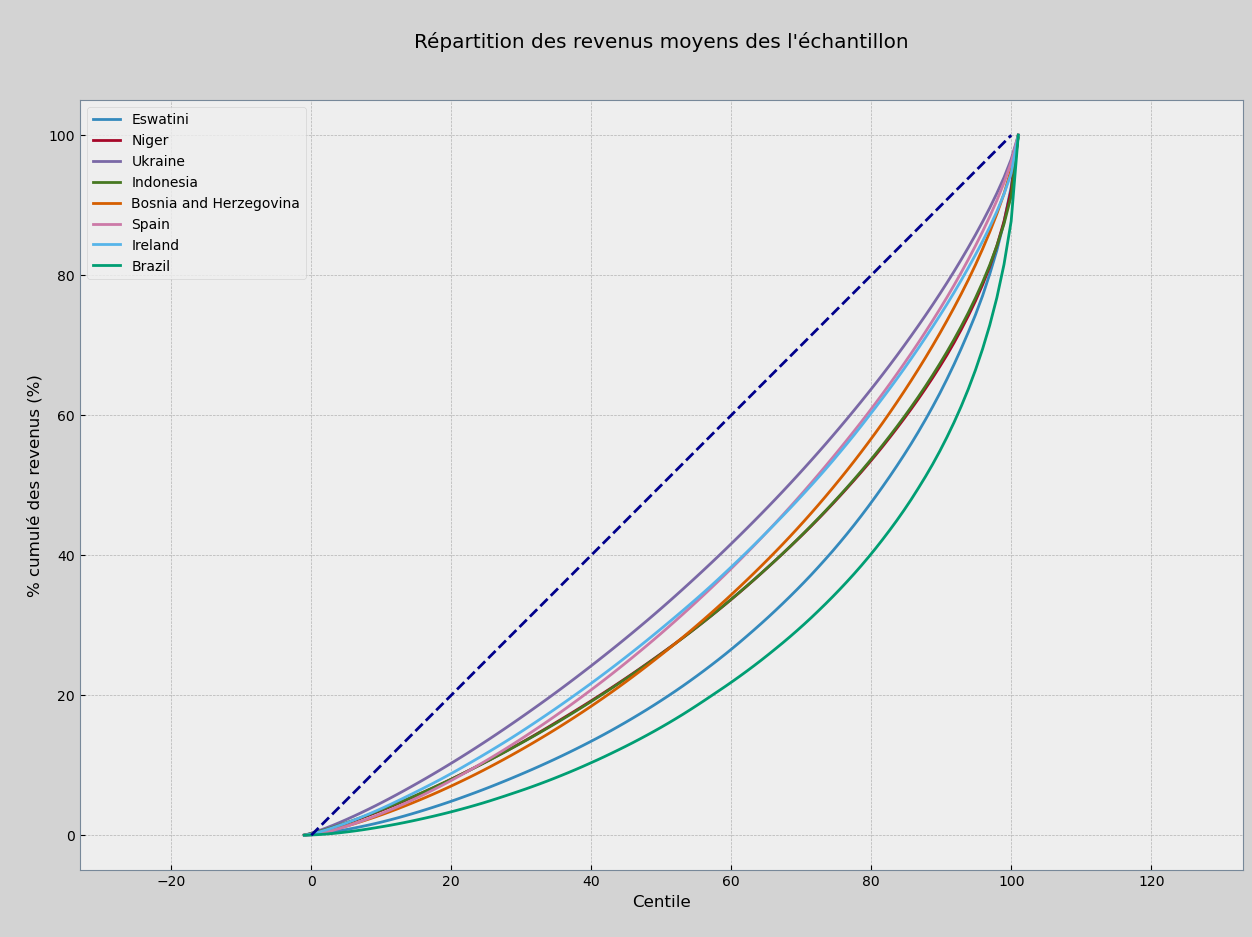

In [75]:
# courbe de Lorenz des revenus "Inégalitaires"
plt.figure(figsize = (15, 10))

plt.axes().axis('equal')
xaxis = np.linspace(0 - 1/n, 1 + 1/n, n + 1)

for pays in echantillon.pays.unique():
    data = echantillon[echantillon.pays == pays].income
    n = len(data)

    lorenz = np.cumsum(np.sort(data)) / data.sum()
    lorenz = np.append([0], lorenz)

    plt.plot(xaxis  * 100, lorenz * 100)

plt.plot([0, 100], [0, 100], color = 'darkblue', linestyle = '--') # courbe égalitaire
plt.legend(echantillon.pays.unique())
plt.ylabel("\n% cumulé des revenus (%)")
plt.xlabel("Centile\n")
plt.title("\nRépartition des revenus moyens des l'échantillon\n\n")
plt.show()

La représentation des courbes de Lorenz permet de mettre davantage en évidence la bipolarité de l'échantillon avec une aire inter-courbe nette entre les deux groupes.  
D'un côté, les pays aux revenus interclasses bas ont un profil inégalitaire marquée: 50% des quantiles ne concentrent que 20% des classes de revenus. De l'autre côté, les pays à hauts revenus ont une répartition plus égalitaire puisque 60% des quantiles représentent environ 40% des revenus .

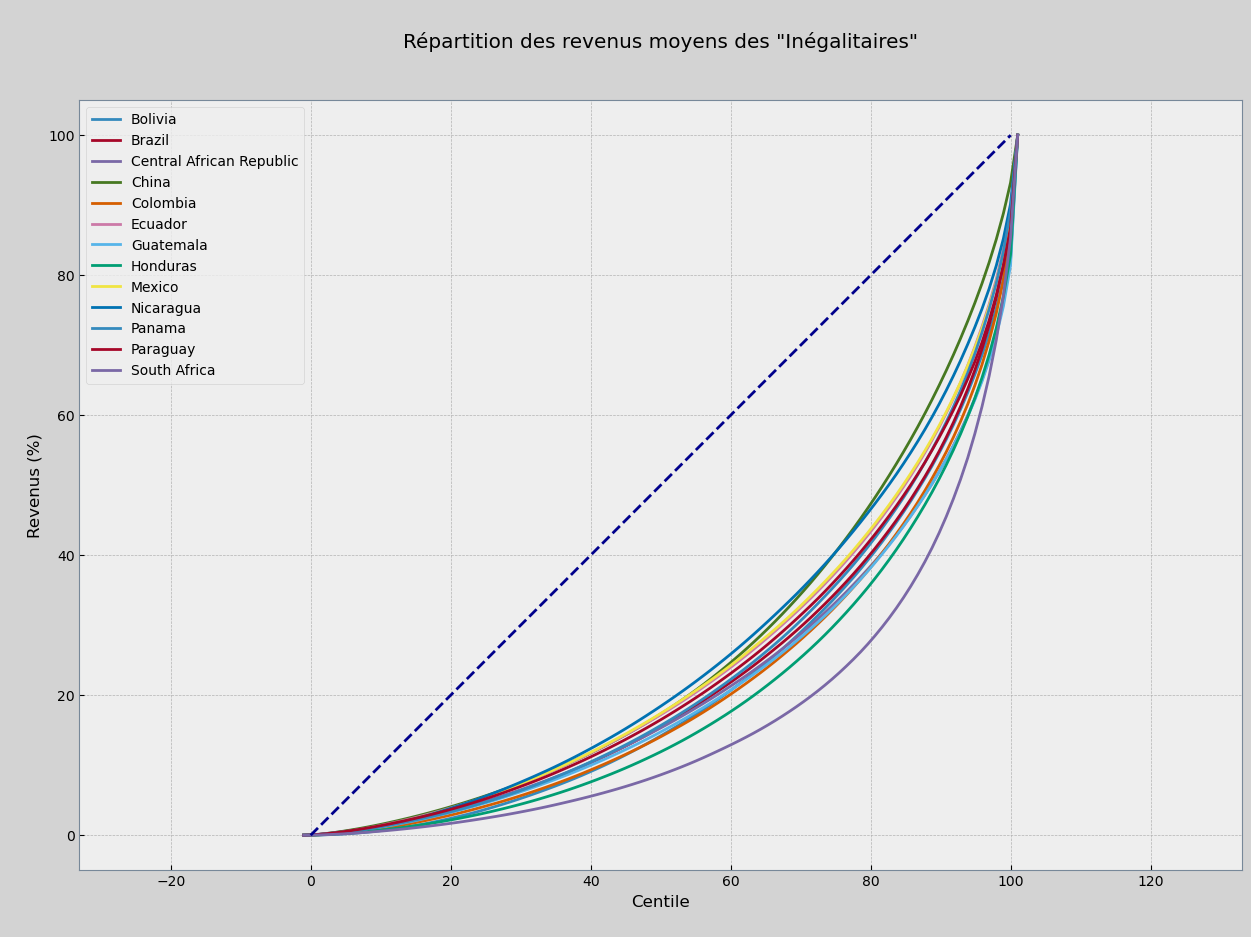

In [76]:
# courbe de Lorenz des revenus "Inégalitaires"
plt.figure(figsize = (15, 10))
n = 100
plt.axes().axis('equal')
xaxis = np.linspace(0 - 1/n, 1 + 1/n, n + 1)

for pays in inegalitaires.pays.unique():
    data = inegalitaires[inegalitaires.pays == pays].income

    lorenz = np.cumsum(np.sort(data)) / data.sum()
    lorenz = np.append([0], lorenz)

    plt.plot(xaxis  * 100, lorenz * 100)

plt.plot([0, 100], [0, 100], color = 'darkblue', linestyle = '--') # courbe égalitaire
plt.legend(inegalitaires.pays.unique())
plt.ylabel("\nRevenus (%)")
plt.xlabel("Centile\n")
plt.title('\nRépartition des revenus moyens des "Inégalitaires"\n\n')
plt.show()

Dans cette représentation graphique, la répartition des revenus de chaque individus des "Inégalitaires" a un comportement quasiment identique avec une courbure particulièrement remarquable pour l'Afrique du Sud où le degré d'inégalité des revenus est extrême: près de 70% des classes de revenus ne représentant que 20% des revenus moyens. A l'opposé, 5% des quantiles concentrent à eux seuls environ, 40% des richesses.  
Ayant dégagé les principales caractéristiques des 3 groupes, nous ne représenterons pas directement l'indice de Gini mais son évolution sur les dernières années.

**Etape 5/6: indice de Gini dans le temps**  
  
Nous avions recalculé les indices de Gini pour les 5 dernières années mais cette représentation, il est plus pertinent de remonter au moins sur une décennie.  
Nous commençons par recréer entièrement le dataframe Indice_gini à partir du df original des revenus (Data_income). Il n'y a pas de restriction sur les individus puisque l'échantillon est créé de façon aléatoire => tous les pays sont potentiellement utilisables. Puis nous passons à la représentation graphique.

In [77]:
# initialisation du df Indice_gini
indice_gini = pd.DataFrame(columns = ['gini'], index = [data_income.country, data_income.year_survey])
indice_gini.drop_duplicates(inplace = True)

In [78]:
code_year = data_income[['country', 'year_survey', 'gdpppp']]
code_year = code_year.drop_duplicates()

code_year.set_index(['country', 'year_survey'], inplace = True)
data_income.set_index(['country', 'year_survey'], inplace = True)

In [79]:
# calcul de l'indice de Gini par pays et par année

n = 100 # taille standard à cause des quantiles
for code, annee in code_year.index.unique():
    data = data_income.loc[(code, annee), 'income'].values
    
# calcul de la courbe de Lorenz
    lorenz = np.cumsum(np.sort(data)) / data.sum()
    lorenz = np.append([0], lorenz)

# calcul de l'indice de Gini
    auc = (lorenz.sum() - lorenz[-1]/2 - lorenz[0]/2) / n
    s = 0.5 - auc
    gini = 2 * s
    indice_gini.loc[(code, annee), 'gini'] = round(gini * 100, 2) # indice en % avec 2 décimales

C:\Users\Dar_ia\AppData\Local\Temp\ipykernel_6216\1917250281.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  data = data_income.loc[(code, annee), 'income'].values


In [80]:
# initialisation + ajout du nom usuel des pays
indice_gini.reset_index(inplace = True)
indice_gini = indice_gini.merge(bdd[['code', 'pays']], left_on = 'country', right_on = 'code')

In [81]:
# arrangement du df
indice_gini.drop('country', axis = 1, inplace = True)
indice_gini.drop_duplicates(inplace = True)

In [82]:
# extraction des pays de l'échantillon
gini = indice_gini[indice_gini.code.isin(echantillon.code)]

In [83]:
# re-indexation pour le graphe de la série temporelle
gini.set_index('year_survey', inplace = True)

###### <span style="color:green">[r2.3]

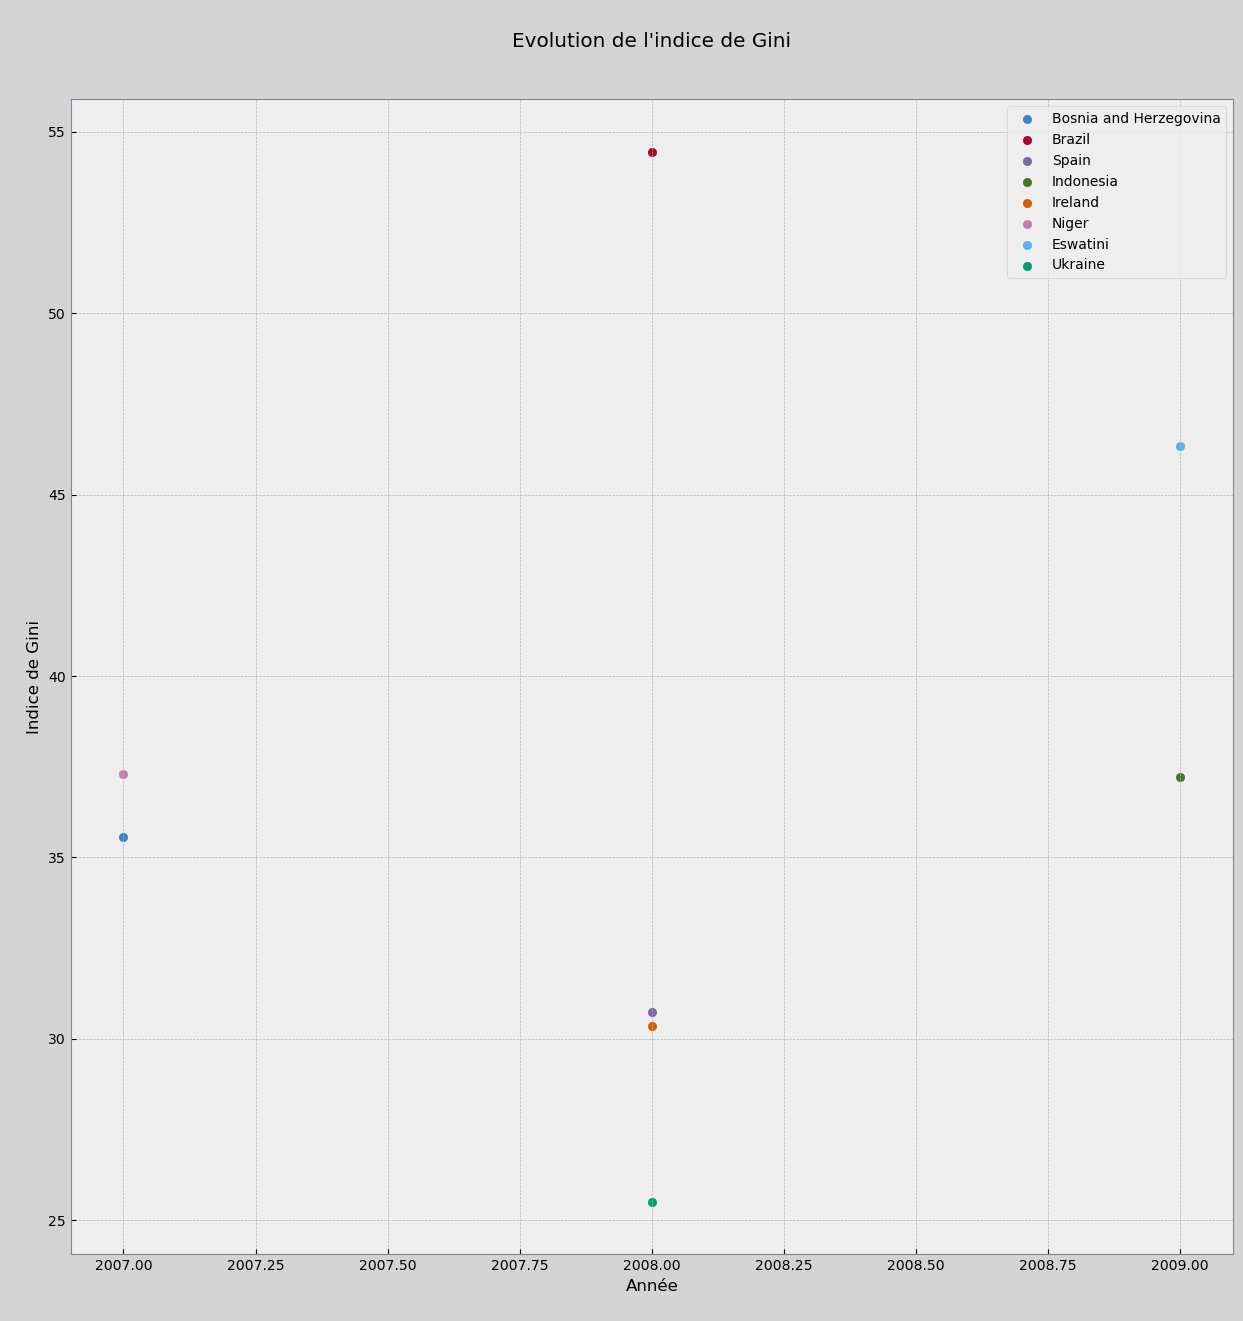

In [84]:
# série temporelle de l'indice de Gini
plt.subplots(figsize = (15, 15))

for pays in gini.pays:
    plt.scatter(gini[gini.pays == pays].index, gini[gini.pays == pays].gini)

plt.legend(gini.pays)
plt.xlabel('Année\n')
plt.ylabel('\nIndice de Gini')
plt.title("\nEvolution de l'indice de Gini\n\n")
plt.show()

La base de données n'étant pas très fournies, les années disponibles par pays ne sont pas optimales pour ne pas dire inexistantes par conséquent, nous ne pouvons apprécier l'évolution de l'indice pour un pays donné. Néanmoins, nous retrouvons la répartition dichotomique des pays de l'échantillon selon la valeur de l'indice de Gini, un pseudo-troisième groupe (grande valeur) étant en réalité, un individu se trouvant à la frontière des pays à forte inégalité.

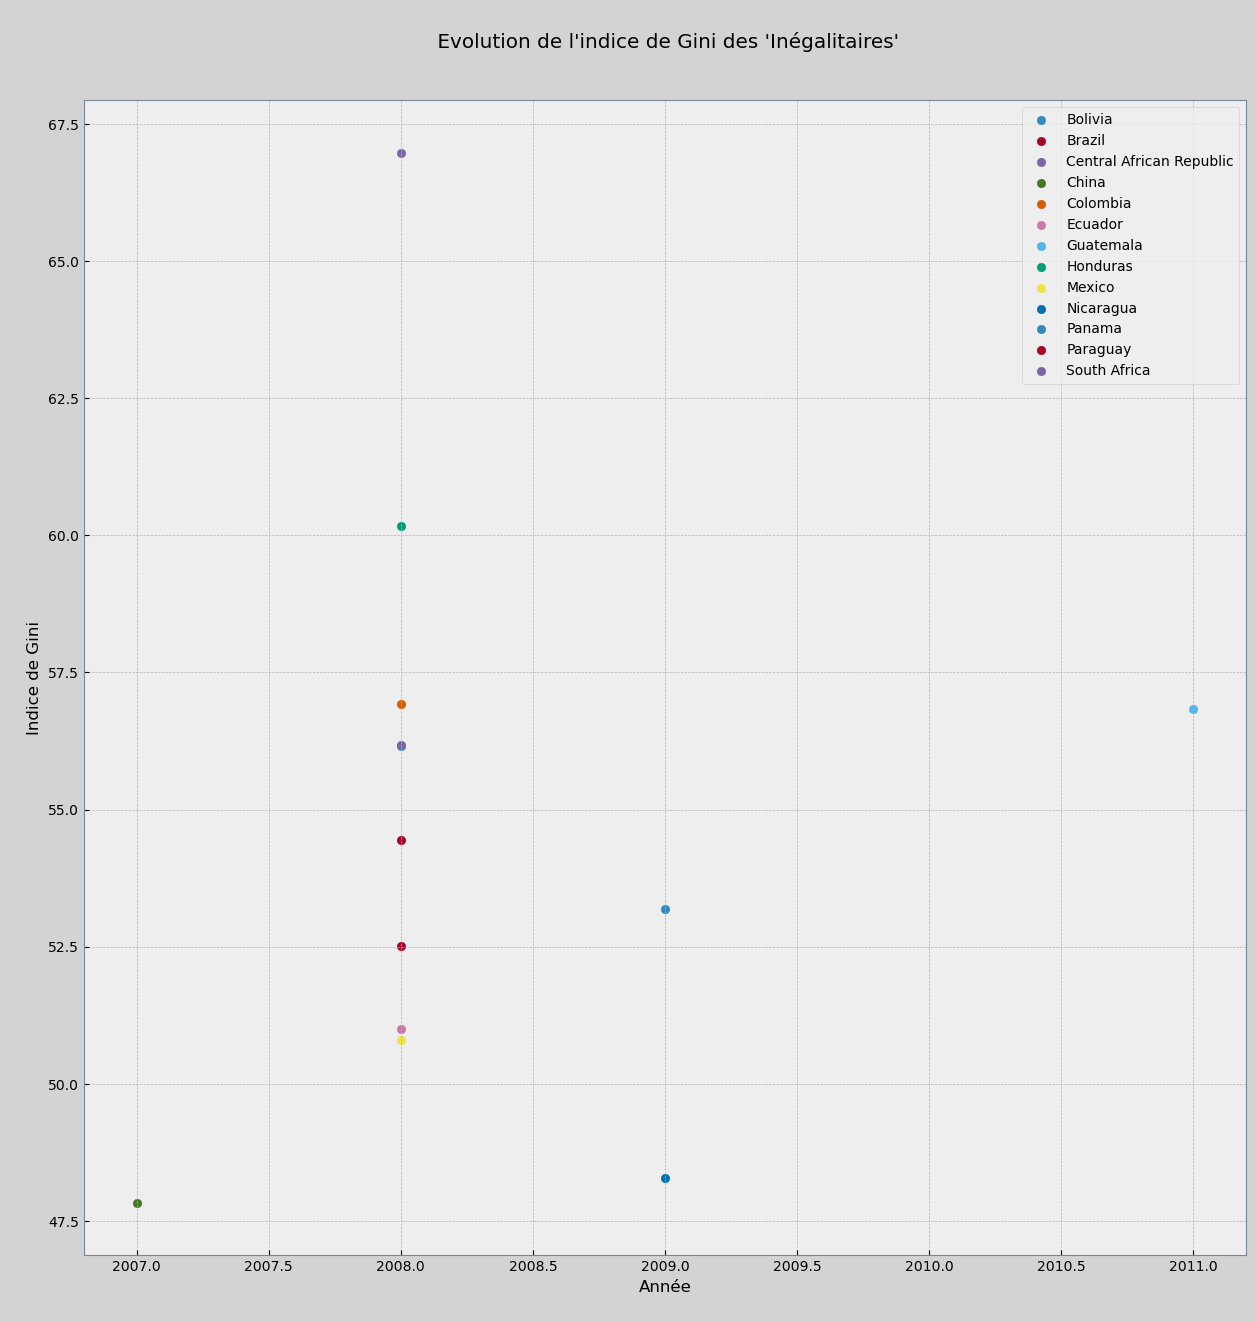

In [85]:
# série temporelle de l'indice de Gini des Inégalitaires
plt.subplots(figsize = (15, 15))

for pays in inegalitaires_ind.pays.unique():
    x = inegalitaires_ind[inegalitaires_ind.pays == pays].year
    y = inegalitaires_ind[inegalitaires_ind.pays == pays].gini
    plt.scatter(x, y)

plt.legend(inegalitaires_ind.pays)
plt.xlabel('Année\n')
plt.ylabel('\nIndice de Gini')
plt.title("\n Evolution de l'indice de Gini des 'Inégalitaires'\n\n")
plt.show()

Pour l'échantillon des "Inégalitaires", les données restent très restreintes. En résumé, ce graphique reste l'expression des courbes de Lorenz à travers l'indice de Gini et n'apporte pas d'informations complémentaires. Néanmoins, nous pouvons connaître les 5 pays se trouvant dans les extrémités de la distribution globale de l'indice de Gini.

###### <span style="color:green">[r2.4]

In [86]:
# trie df df par indice de Gini
indice_gini.sort_values('gini', ignore_index = True, inplace = True)

In [87]:
print("\n5 pays ayant une répartition des revenus la plus égalitaire :")
indice_gini[['pays', 'gini']].head()


5 pays ayant une répartition des revenus la plus égalitaire :


,pays,gini
0,Slovenia,23.07
1,Slovak Republic,24.72
2,Czech Republic,25.29
3,Sweden,25.49
4,Ukraine,25.51


In [88]:
print("\n5 pays aux inégalités de revenus les plus importantes :")
indice_gini[['pays', 'gini']].tail()


5 pays aux inégalités de revenus les plus importantes :


,pays,gini
104,Central African Republic,56.17
105,Guatemala,56.83
106,Colombia,56.93
107,Honduras,60.17
108,South Africa,66.98


In [89]:
print("\nLa France se trouve à la", indice_gini[indice_gini.pays == 'France'].index[0], "ème place sur 108 pays.")


La France se trouve à la 38 ème place sur 108 pays.


#### [**3. Mission 3: construction du modèle**](#table-des-matières)  
  
Lors de cette mission, nous tachons de construire un modèle permettant de prédire la classe de revenus d'un enfant en fonction de la classe parentale. Lors de cette construction, nous posons les hypothèses principales suivantes:  
- la classe de revenus parentale ne fait pas de différence entre le nombre de parents;  
- le modèle ne prend pas en compte les changements de classes intragénérationnelles (parent ou enfant);  
- le modèle considère uniquement les revenus perçus sur le long terme, excluant donc les revenus de type prime, avantages, etc.  
  
La construction du modèle va se faire en 4 étapes directrices.  
- nous commençons par générer les revenus des enfants en fonction de ceux des parents selon la loi qui les unit;  
- nous récupérons les classes de revenus correspondant pour chaque partie;  
- nous estimons les probabilités conditionnelles de chaque classe parentale sachant celles des enfants;  
- nous utilisons les données des revenus par pays pour établir les probabilités réelles pour chaque pays.

##### [**3.1 Bases du modèle: lien entre les revenus parent/enfant**](#table-des-matières)  
  
La direction de cette partie suit le loi logarithmique qui régit les revenus des enfants en fonction de ceux des parents. Cette loi est admise et ne fera donc pas l'objet d'une démonstration ici mais, pour pouvoir l'appliquer, nous devons commencer par récupérer la liste des coefficients d'élasticité de chaque pays.  
Ensuite, parce que nous nous concentrons sur les lois qui régissent les revenus et non leurs informations statistiques, nous n'avons pas besoin  de travailler sur des valeurs réelles, par conséquent, nous générons des revenus parentaux fictifs dont la distribution suit la gaussienne et enfin, nous appliquons à ces données, la loi logarithmique ci-dessus afin d'obtenir de façon cohérente les revenus des enfants pour chaque pays.  
Ces deux revenus seront stockés dans un dataframe appelé "Modèle".

In [90]:
elasticity = pd.read_csv('coeff_elasticite.csv')

In [91]:
# aperçu des données 1
elasticity.columns

Index(['country', 'code', 'region', 'region_noHICgroup', 'incgroup2',
       'incgroup3', 'incgroup4', 'fragile', 'survey', 'year', 'status',
       'cohort', 'parent', 'child', 'obs', 'P1', 'P2', 'P3', 'P4', 'P5', 'C1',
       'C2', 'C3', 'C4', 'C5', 'MEANp', 'MEANc', 'SDp', 'SDc', 'MLD_psu',
       'CAT', 'YOS', 'DIF', 'MIX', 'CAT_ISCED0', 'CAT_ISCED1', 'CAT_ISCED2',
       'CAT_ISCED34', 'CAT_ISCED5678', 'COR', 'BETA', 'MU050', 'BHQ4', 'Q4Q4',
       'BHQ1', 'BHQ2', 'BHQ3', 'Q4BH', 'Q4child'],
      dtype='object')

In [92]:
# aperçu des données 2
elasticity.head(3)

,country,code,region,region_noHICgroup,incgroup2,incgroup3,incgroup4,fragile,survey,year,...,COR,BETA,MU050,BHQ4,Q4Q4,BHQ1,BHQ2,BHQ3,Q4BH,Q4child
0,Afghanistan,AFG,South Asia,South Asia,Developing economies,Low income,Low income,Yes,NRVA,2011,...,0.521676,0.802107,38.267929,0.115412,0.576567,0.343300,0.325300,0.215988,0.160665,0.250315
1,Afghanistan,AFG,South Asia,South Asia,Developing economies,Low income,Low income,Yes,NRVA,2011,...,0.576251,0.848156,31.926859,0.069982,0.505354,0.439815,0.384448,0.105754,0.284408,0.216944
2,Afghanistan,AFG,South Asia,South Asia,Developing economies,Low income,Low income,Yes,NRVA,2011,...,0.521442,0.807674,39.630493,0.125021,0.599029,0.322886,0.312750,0.239342,0.121790,0.258574


Les données de la GDIM sont très détaillées jusqu'à inclure, par exemple, le niveau scolaire des parents et enfants or nous avons choisi la version "simple" de la mobilité intergénérationnelle des revenus autrement dit, celle qui relie les logarithmes des revenus parents/enfants uniquement. Toutes ces précisions, bien qu'intéressantes, ne sont pas utiles dans ce contexte. Nous ne conservons que les codes, les années et les coefficients "basiques" puis passons aux nettoyages.

In [93]:
elasticity = elasticity[['code', 'year', 'CAT']]

In [94]:
# présence de valeurs NaN?
elasticity.isna().any().any()

False

In [95]:
# présence de valeurs non sigificatives?
elasticity.dtypes

code     object
year      int64
CAT     float64
dtype: object

In [96]:
# présence de doublons?
elasticity.shape[0] - elasticity.drop_duplicates().shape[0]

92

In [97]:
elasticity.drop_duplicates(inplace = True)

In [98]:
# renommage rapide de la colonne 'CAT'
elasticity.columns = ['code', 'year', 'coeff']

In [99]:
elasticity.head(2)

,code,year,coeff
0,AFG,2011,0.414355
1,AFG,2011,0.283075


Pas de valeurs NaN, types de données cohérents avec les variables, doublons traités, colonne renommée.

Parce que différents paramètres sont utilisés pour l'estimation du coefficient, nous avons pour un même pays et une même année, plusieurs valeurs. Nous comparons moyenne et la médiane des coefficients pour chaque pays. Si les 2 décimales sont identiques, nous considérons la présence/influence de valeurs outliers nulles/négligeables et considérons la moyenne. Sinon, la médiane.

In [100]:
# pour ne pas à surcharger le df des coefficients
difference = pd.DataFrame()

In [101]:
# calcul de la moyenne/médiane des coeff. par pays
difference['moy'] = elasticity.groupby(['code', 'year']).coeff.mean()
difference['med'] = elasticity.groupby(['code', 'year']).coeff.median()

In [102]:
# différence entre la moyenne et la médiane du coeff.
difference['diff'] = difference.moy - difference.med

In [103]:
# individus ayant une différence absolue moyenne-médiane de plus de 1%
idx = difference[abs(difference['diff']) > 0.01]

In [104]:
elasticity.set_index(['code', 'year'], inplace = True)

In [105]:
# individus peu robustes => utilisation de la médiane
elasticity.loc[elasticity.index.isin(idx.index), 'coeff'] = difference.med

In [106]:
# individus robustes => utilisation de la moyenne
elasticity.loc[elasticity.index.isin(idx.index) == False, 'coeff'] = difference.med

In [107]:
# trie sur l'année la plus récente
elasticity = elasticity.groupby(['code', 'year']).max('year')

In [108]:
elasticity = elasticity.droplevel(1)
elasticity.reset_index(inplace = True)

Les coefficients d'élasticité sont présents. Nous passons aux revenus parentaux.  
Nous avons 20 quantiles => nous devons générer 20 000 revenus.  
Rappel de la loi suivie:  
$Y_{child}$ = exp[$p_{i}$.ln($Y_{parent}$) + $\epsilon$], $p_{i}$ le coeff. d'élasticité.

In [109]:
# fonction générant n revenus en fonction du coeff pj
def generate_income(n, pj):
    ln_y_parent = st.norm(0, 1).rvs(size = n) # suivant la gaussienne
    residues = st.norm(0, 1).rvs(size = n)
    return np.exp(pj * ln_y_parent + residues), np.exp(ln_y_parent)

In [110]:
# préparation du matériels
modele = pd.DataFrame(columns = ['code', 'coeff', 'revenu_e', 'revenu_p'])
df = pd.DataFrame(columns = ['revenu_p', 'residu', 'revenu_e'])
elasticity.set_index(['code', 'coeff'], inplace = True)

Maintenant, nous allons générer une suite de revenus fictifs en suivant la gaussienne et procédons de même pour le calcul des résidus.
###### <span style="color:green">[r3.1]
###### <span style="color:green">[r3.2]
Afin de profiter des itérations sur les pays et coefficients d'élasticité, nous calculons dans la même boucle "for", le revenu fictif des enfants en appliquant la relation exponentielle introduite en début de partie.
###### <span style="color:green">[r3.3]

In [111]:
# pour chaque couple (code, coeff.) = n x 20 quantiles réalisations
for code, coeff in elasticity.index:
    revenu = st.norm(0, 1).rvs(size = 20000) # générateur normalien aléatoire
    residu = st.norm(0, 1).rvs(size = 20000)
    df['revenu_p'] = np.exp(revenu)
    df['residu'] = residu
    df['revenu_e'] = np.exp(coeff * revenu + residu) # calcul du revenu enfant

    modele = pd.concat([modele, df[['revenu_p', 'revenu_e']]])
    modele.loc[modele.code.isna(), 'code'] = code # nettoyage local
    modele.loc[modele.coeff.isna(), 'coeff'] = coeff

C:\Users\Dar_ia\AppData\Local\Temp\ipykernel_6216\3621630295.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  modele = pd.concat([modele, df[['revenu_p', 'revenu_e']]])


##### [**3.2 Corps du modèle: classes de revenus parent/enfant**](#table-des-matières)  
  
Nous avons un ensemble d'individus fictifs caractérisé par le code du pays, le coeff. d'élasticité réel correspondant et deux revenus fictifs, l'un parent et l'autre, enfant. Il nous faut déterminer leur classe des revenus respective. Il est évident que nous ne pouvons pas nous appuyer sur les précédents dataframes concernant les revenus.  
Nous allons nous servir d'une fonction du cours permettant de retourner le quantile couplé à chaque valeur d'une série. Cette fonction est appliquée aux colonnes "revenu_p" et "revenu_e" du modèle pour chaque pays. Nous rappelons que le nombre d'individus créés dépend directement de la taille de l'échantillon par pays, ie n = 20 000.
###### <span style="color:green">[r3.4]

In [112]:
modele.head() # rappel

,code,coeff,revenu_e,revenu_p
0,AFG,0.358037,3.393569,0.936479
1,AFG,0.358037,3.277365,3.636692
2,AFG,0.358037,1.434077,0.946391
3,AFG,0.358037,0.313776,0.900350
4,AFG,0.358037,6.789968,2.863512


In [113]:
# préparation de la colonne 'quantile'
modele.insert(2, 'quantile_e', 0)
modele['quantile_p'] = 0

In [114]:
# fonction retournant les classes de revenus d'une série l
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a, b in zip(l_sorted, quantiles)} # rattache le quantile à sa valeur "série"
    return pd.Series([q_dict[e] for e in l])

Afin d'éviter les coûts d'instruction, nous sauvegardons les données produites par les deux prochaines cellules au format csv et les réimportons. Libre au lecteur de "décommenter" ces instructions et de la faire tourner.  
Cœur à 2.6 GHz et RAM = 15 Go -> temps(exe) ~  2mn 10s.

In [115]:
# calcul des classes de revenus pour chaque pays
'''for code in modele.code.unique():
    distribution_p = modele[modele.code == code].revenu_p # extraction des données
    distribution_e = modele[modele.code == code].revenu_e

    modele.loc[modele.code == code, 'quantile_p'] = quantiles(distribution_p, 20)
    modele.loc[modele.code == code, 'quantile_e'] = quantiles(distribution_e, 20)'''

"for code in modele.code.unique():\n    distribution_p = modele[modele.code == code].revenu_p # extraction des données\n    distribution_e = modele[modele.code == code].revenu_e\n\n    modele.loc[modele.code == code, 'quantile_p'] = quantiles(distribution_p, 20)\n    modele.loc[modele.code == code, 'quantile_e'] = quantiles(distribution_e, 20)"

In [116]:
# exportation de BDD_Modele au format csv
# modele.to_csv('modele_lecteur.csv', index = False)

In [117]:
# importation de Modele
modele = pd.read_csv('modele.csv')

##### [**3.3 Paramétre du modèle: probabilité de la mobilité des revenus**](#table-des-matières)  
  
Nous abordons la phase la phase de construction principale du modèle. Il s'agit d'utiliser les classes de revenus enfants et parents afin d'établir la probabilité conditionnelle d'avoir telle classe parent en partant de celle de l'enfant.  
  
Pour ce faire, les étapes:  
- Création d'un dictionnaire (Proba_cond): [clef = code du pays, valeur = tableau];  
- Le tableau :  
    -- création d'une fonction retournant un tableau de contingence;  
    -- les entrées: les classes de revenus parents(c_p)/enfants (c_e);  
    -- les valeurs: les effectifs pour chaque couple de classe parent/enfant;  
    -- les proba. conditionnelles: directement données dans la foulée du tab. de contingence pour alléger les calculs: pour rappel, nombre d'individu ayant une classe de revenu enfant c_e = n est de 1000, ∀ n ∈ [[1, 20]]  
    => P(c_p|c_e) = effectif(c_p, c_e) / 1000 (x100 pour le %).

In [118]:
# initialisation du dictionnaire
proba_cond = {}

###### <span style="color:green">[r3.5]

In [119]:
# fonction créant le tableau de contingence
def tab_contingence(df):
    X = "quantile_p" # quantiles enfant et parent
    Y = "quantile_e"

    cont_effectif = df[[X,Y]].pivot_table(
        index = X,
        columns = Y,
        aggfunc = len, # effectif pour une classe parent/enfant donnée
        margins = False
        )
    cont_pourct = cont_effectif.fillna(.1) / 1000 # pas de x100 (%) : allègement des futurs calculs
    return(cont_pourct)

In [120]:
# application de la fonction et création du couple clef-tableau pour chaque pays    
for code in modele.code.unique():
    df = modele[modele.code == code] # stockage des individus du pays 'code' = - de calcul
    proba_cond[code] = tab_contingence(df)

In [121]:
# force l'affichage des 20 colonnes
pd.set_option('display.max_columns', None)

In [122]:
# exemple de proba. conditionnelle de la France pour [r3.5]
proba_cond['FRA']

quantile_e,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
quantile_p,,,,,,,,,,,,,,,,,,,,
1,0.288,0.166,0.118,0.081,0.072,0.044,0.050,0.044,0.042,0.030,0.015,0.017,0.005,0.006,0.010,0.004,0.004,0.004,0.0001,0.0001
2,0.148,0.123,0.111,0.113,0.074,0.073,0.048,0.057,0.049,0.046,0.038,0.030,0.017,0.024,0.019,0.014,0.005,0.007,0.0030,0.0010
3,0.122,0.118,0.092,0.089,0.084,0.077,0.062,0.058,0.059,0.045,0.032,0.028,0.036,0.031,0.014,0.021,0.015,0.011,0.0030,0.0030
4,0.093,0.105,0.086,0.097,0.076,0.063,0.062,0.063,0.042,0.052,0.046,0.048,0.042,0.027,0.031,0.023,0.017,0.014,0.0090,0.0040
5,0.061,0.076,0.094,0.069,0.073,0.076,0.062,0.063,0.059,0.048,0.054,0.047,0.057,0.042,0.033,0.018,0.022,0.024,0.0150,0.0070
6,0.057,0.067,0.076,0.065,0.063,0.063,0.077,0.071,0.050,0.055,0.068,0.051,0.052,0.039,0.036,0.043,0.029,0.017,0.0150,0.0060
7,0.047,0.053,0.066,0.062,0.079,0.052,0.070,0.060,0.070,0.065,0.052,0.060,0.041,0.048,0.043,0.035,0.031,0.037,0.0170,0.0120
8,0.052,0.060,0.057,0.052,0.063,0.067,0.081,0.073,0.062,0.059,0.065,0.065,0.033,0.042,0.047,0.046,0.022,0.024,0.0250,0.0050
9,0.027,0.047,0.057,0.055,0.052,0.069,0.062,0.069,0.054,0.057,0.064,0.064,0.057,0.049,0.048,0.052,0.034,0.032,0.0360,0.0150


In [123]:
# vérification de la cohérence des résultats
proba_cond['FRA'].sum()

quantile_e
1     1.0000
2     1.0000
3     1.0000
4     1.0000
5     1.0000
6     1.0000
7     1.0000
8     1.0000
9     1.0000
10    1.0000
11    1.0000
12    1.0000
13    1.0000
14    1.0000
15    1.0000
16    1.0000
17    1.0000
18    1.0000
19    1.0001
20    1.0001
dtype: float64

La somme de toutes les probabilités conditionnelles sachant chaque quantile enfant est égale à 1 (100%) donc les résultats sont bien statistiquement cohérents.
  
Afin d'avoir d'avoir un meilleur visuel sur les matrices de probabilités conditionnelles et de vérifier les résultats obtenus en fonction des coefficients d'élasticité, nous représentons ces matrices sous formes de stacks bar.  
Nous choisisons 3 individus ayant un coefficient d'élasticité dans les valeurs extrêmes et un dans les valeurs médianes. Nous choisisons Taïwan (TWN), la France (FRA) et le Soudan du Sud (SSD).

In [124]:
elasticity.reset_index(inplace = True)

In [125]:
choix = elasticity[(elasticity.code == 'FRA') | (elasticity.code == 'TWN') | (elasticity.code == 'SSD')].sort_values('coeff')
print("\nRappel des coefficients d'élasticité des pays choisis:")
choix


Rappel des coefficients d'élasticité des pays choisis:


,code,coeff
129,SSD,0.054612
46,FRA,0.694143
144,TWN,0.907738


In [126]:
# affectation des noms usuels
choix['pays'] = ['Soudan du Sud', 'France', 'Taïwan']
choix.set_index('pays', inplace = True)

###### <span style="color:green">[r3.6]

C:\Users\Dar_ia\AppData\Local\Temp\ipykernel_6216\384429417.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title("\nMobilité du pays: {}\n p = {}\n\n".format(choix[choix.code == code].index[0], round(choix[choix.code == code].coeff[0], 2)))


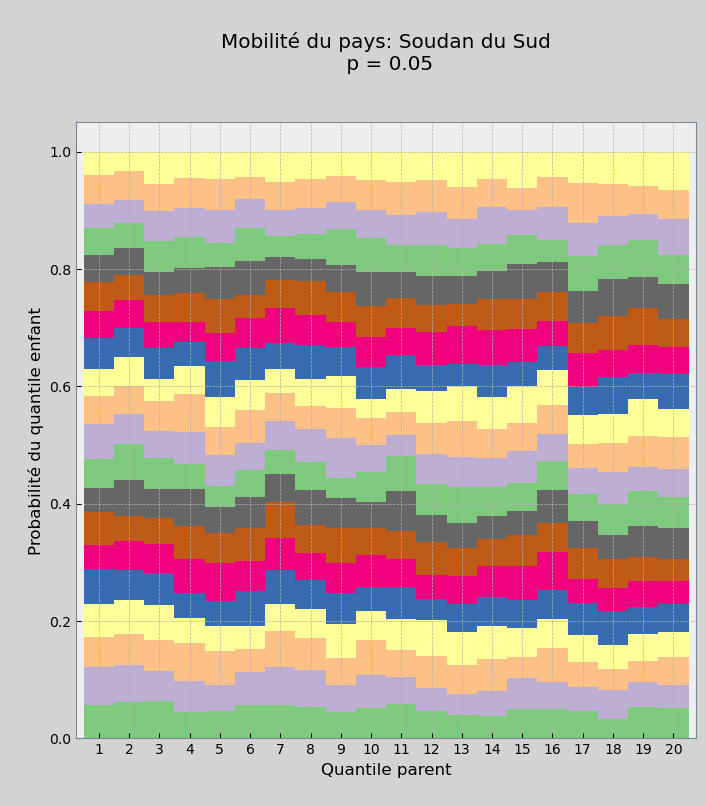

C:\Users\Dar_ia\AppData\Local\Temp\ipykernel_6216\384429417.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title("\nMobilité du pays: {}\n p = {}\n\n".format(choix[choix.code == code].index[0], round(choix[choix.code == code].coeff[0], 2)))


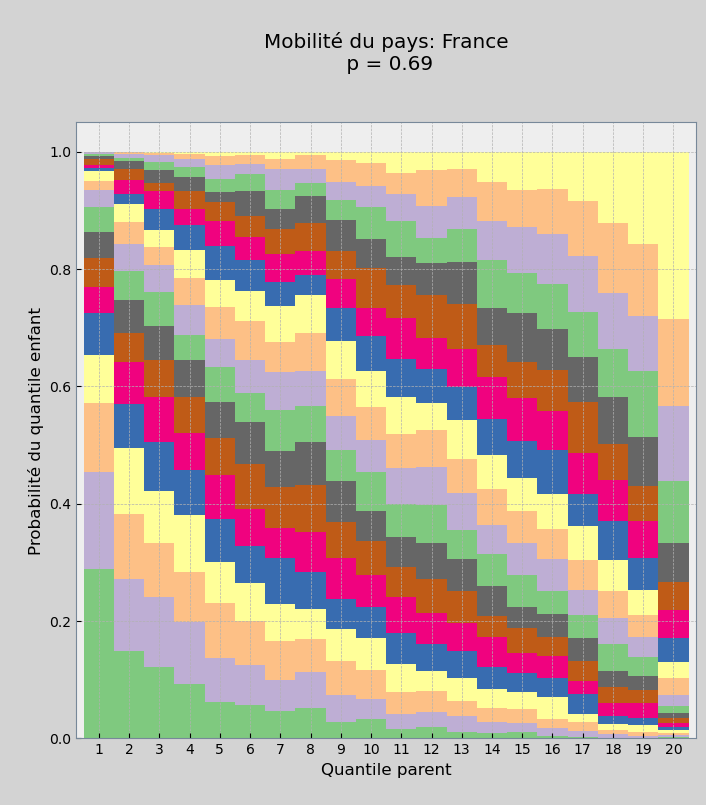

C:\Users\Dar_ia\AppData\Local\Temp\ipykernel_6216\384429417.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.title("\nMobilité du pays: {}\n p = {}\n\n".format(choix[choix.code == code].index[0], round(choix[choix.code == code].coeff[0], 2)))


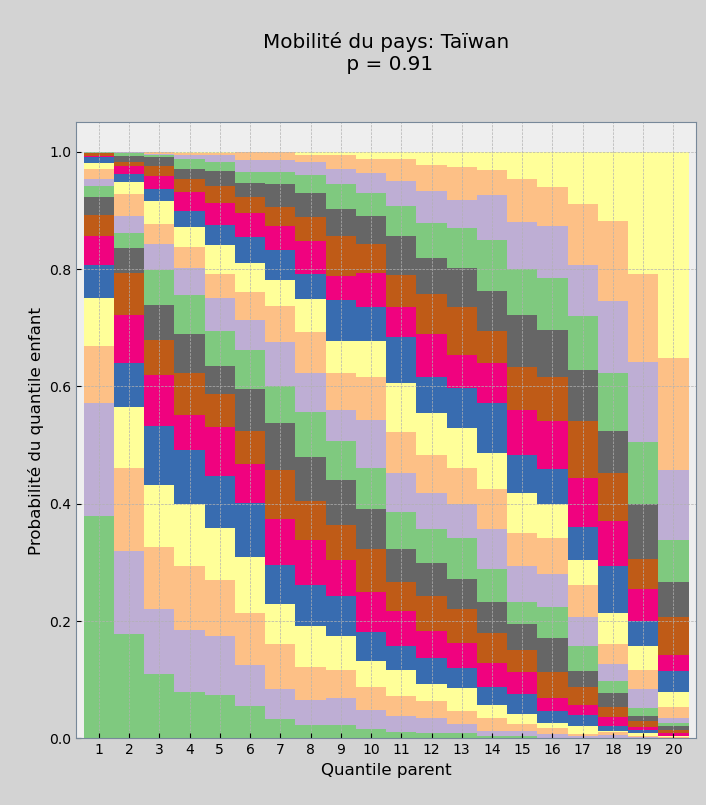

In [127]:
# stacked bar pour les pays choisis
for code in choix.code:
       df = proba_cond[code].copy()
       df.reset_index(inplace = True)
       df.plot(
              x = 'quantile_p',
              kind = 'bar',
              stacked = True,
              width = 1,
              color = plt.get_cmap('Accent').colors,
              figsize = (8, 8)
              )

       plt.xticks(rotation = 0)
       plt.xlabel('Quantile parent\n')
       plt.ylabel('\nProbabilité du quantile enfant')
       plt.title("\nMobilité du pays: {}\n p = {}\n\n".format(choix[choix.code == code].index[0], round(choix[choix.code == code].coeff[0], 2)))
       plt.legend().set_visible(False)
       plt.show()

Les graphiques obtenus sont cohérents avec les stacked bar charts témoins.  
Nous remarquons des instabilités dans la régularité du coefficient le plus proche de 0 par rapport au graphique témoin. La symétrie quasi-parfaite du cas le plus extrême que représente la Taïwan par rapport à la diagonale et dont le coefficient d'élasticité est poche des 100% rappellent l'ancienne expression d'hérédité sociale. Ainsi, en Taïwan où la mobilité intergénérationnelle est proche de 0, un enfant né dans une classe sociale extrême, présente une probabilité de presque 40% d'appartenir lui-même à la même classe de revenu que ces parents. Cette probabilité atteint les 60% si l'on considère la deuxième classe de revenus adjacente.

###### <span style="color:green">[r3.7]

In [128]:
# suppression des salaires fictifs
modele.drop(['revenu_e', 'revenu_p'], axis = 1, inplace = True)

Nous allons passer à l'application du modèle sur les revenus réels des pays des prospects => nous supprimons les codes pays n'en faisant pas partie.

In [129]:
# nettoyage des codes obsolètes
elasticity = elasticity[elasticity.code.isin(bdd.code)].reset_index()
modele = modele[modele.code.isin((bdd.code))].reset_index()

In [130]:
# création d'un autre dictionnaire pour les changements de proba_cond
proba_condition = {}

In [131]:
# nettoyage des clefs absentes dans les codes de BDD
for key in proba_cond:
    if key in bdd.code.values:
        proba_condition[key] = proba_cond[key]

##### [**3.4 Modèle et réalité: les classes de revenus**](#table-des-matières)  
  
Pour chaque pays, nous venons d'établir les probabilités conditionnelles d'appartenir à une classe de revenu parent sachant celle d'un enfant. Puisque le travail était axé sur les lois qui régissent les classes de revenu, les individus utilisés étaient fictifs.  
Dans cette partie, nous revenons dans la réalité et appliquons les lois du modèle aux revenus réels des pays.  
  
**Les étapes:**  
    o Préparation des données: les quantiles et les individus;  
    o Les proba. conditionnelles dans la réalité: application de Modèle et de ses tables de lois (proba. conditionnelles);  
    o Vernissage des données: suppression de variables, vérification des paramètres.  
  
**Résumé des formats principaux utilisés:**  
    o BDD : revenus et quantiles des revenus de toutes les pays;  
    o BDD_ind : population, gini et interdéciles des pays;  
    o Modele : df contenant le code pays, le coeff. d'élasticité et les classes de revenus;  
    o Proba_cond : dictionnaire des proba. conditionnelles  
        - clef = code d'un pays;  
        - valeur = matrice des proba. (%) des classes de revenus parent/enfant.  
    o Df: utilisé pour les opérations intermédiaires.

##### **3.4.1 Préparation des individus**  
  
**Étapes:**  
- Nous récupérons les données des revenus réels;  
- Le modèle reposant sur 20 classes de revenus, nous réassignons les quantiles des revenus sur cette échelle;  
- Données stockées sous BDD_20qt (quantiles, df nommé car réutilisé plus tard);  
- Les nouvelles données multipliées par 500 sont stockées sous "Clone".

In [132]:
# extraction des variables utiles
bdd_20qt = bdd[['code', 'pays', 'gini', 'quantile', 'income']].copy()

In [133]:
# màj des échelles de quantiles à 20 classes
for code in bdd_20qt.code.unique():
    df = bdd_20qt[bdd_20qt.code == code].income
    bdd_20qt.loc[bdd_20qt.code == code, 'quantile'] = quantiles(df, 20).values # fonction (df, nb_quantile_choisi)

In [134]:
bdd_20qt.head(2)

,code,pays,gini,quantile,income
0,ALB,Albania,30.46,1,728.89795
1,ALB,Albania,30.46,1,916.66235


In [135]:
bdd_20qt.shape

(10899, 5)

###### <span style="color:green">[r3.8]

In [136]:
# clonage de chaque individu du dataframe
clone = pd.concat([bdd_20qt] * 500)

In [137]:
clone.reset_index(drop = True, inplace = True)

In [138]:
clone.shape

(5449500, 5)

##### **3.4.2 Probabilité réelle**  
  
Nous avons les classes de revenus "niveau enfant". Pour obtenir les quantiles "niveau parent", nous appliquons les lois des tables de probabilité conditionnelle aux données réelles de Clone.  
Nous rappelons que ces proba. sont contenues dans les valeurs du dictionnaire Proba_condition ayant pour clef, les codes de pays.  

In [139]:
# rappel d'un df de proba. conditionnelles: FRA = France
proba_condition['FRA'].head()

quantile_e,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
quantile_p,,,,,,,,,,,,,,,,,,,,
1,0.288,0.166,0.118,0.081,0.072,0.044,0.050,0.044,0.042,0.030,0.015,0.017,0.005,0.006,0.010,0.004,0.004,0.004,0.0001,0.0001
2,0.148,0.123,0.111,0.113,0.074,0.073,0.048,0.057,0.049,0.046,0.038,0.030,0.017,0.024,0.019,0.014,0.005,0.007,0.0030,0.0010
3,0.122,0.118,0.092,0.089,0.084,0.077,0.062,0.058,0.059,0.045,0.032,0.028,0.036,0.031,0.014,0.021,0.015,0.011,0.0030,0.0030
4,0.093,0.105,0.086,0.097,0.076,0.063,0.062,0.063,0.042,0.052,0.046,0.048,0.042,0.027,0.031,0.023,0.017,0.014,0.0090,0.0040
5,0.061,0.076,0.094,0.069,0.073,0.076,0.062,0.063,0.059,0.048,0.054,0.047,0.057,0.042,0.033,0.018,0.022,0.024,0.0150,0.0070


**Ce que l'on veut:**  
Nous cherchons le nombre d'individus $N_{C_{ij}}$ d'un quantile parent ayant pour probabilité d'existence: $P(C_{p}\bigcap C_{e})$ = $\frac{P(C_{p}|C_{e})}{P(C_{e})}$:  
- $C_{p}$ et $C_{e}$ sont respectivement, un quantile parent et un quantile enfant quelconques;  
- $P(C_{p}|C_{e})$: est donnée par les valeurs de Proba_cond pour un couple de quantiles parent/enfant $C_{p_{i}}$|$C_{e_{j}}$ donné (%);  
- $P(C_{e})$ = $\frac{effectif(C_{e})}{effectif  total}$ = $\frac{500}{10 000}$ = 0.05;  
=> $P(C_{p} \bigcap C_{e})$ = 0.05 x $P(C_{p}|C_{e})$  
  
=> Nombre d'individus $N_{C_{ij}}$:  
$N_{C_{ij}}$ = $P(C_{p} \bigcap C_{e})$ x $effectif_{échantillon}$ = $P(C_{p} \bigcap C_{e})$ x 10000 = 0.05 x $P(C_{p}|C_{e})$ x 10000 = $P(C_{p}|C_{e})$ x 500  
=> $N_{C_{ij}}$ d'un pays code $CODE_{pays}$ <=> Proba_cond['$CODE_{pays}$']$_{ij}$ x 500
  
**Etapes:**  
- Calcul de l'ensemble du nombre conditionnel d'individus directement d'après le dictionnaire Proba_condition, données stockées dans le dictionnaire Nb_cond;  
- création d'une colonne pour les quantiles parents: "Quantile_p";  
- affectation des nouvelles classes de quantile parent: pour chaque individu de classe enfant C_e, nous affectons à $N_{C_{ep}}$ individus le quantile parent C_p.  
  
**o Etape 1/3 : le dictionnaire Nb_cond**

In [140]:
nb_cond = {}

In [141]:
# matrice du nombre d'individus selon les proba. conditionnelles de chaque pays
for key in proba_condition:
    nb_cond[key] = proba_condition[key] * 500

**o Etape 2/3: préparation du dataframe des clones**

In [142]:
# colonne des quantiles parent
clone.insert(clone.shape[1], 'quantile_p', 0)

**o Etape 3/3: affectation des classes de revenus niveau parent**  
  
Nous créons une fonction. Ses grandes lignes:  
- Prend en entrée:  
    - Nb_cond['pays']: le dictionnaire du nombre d'individus sous les lois de proba. conditionnelles d'un pays;  
    - Code: un code pays = clef du dictionnaire Nb_cond;  
    - BDD_20qt: df des revenus réels par pays avec quantiles enfant par 20;
    - Model: futur df qui stockera les quantiles enfant/parent;  
- Extrait chaque nombre d'individus $N_{ij}$ d'un couple de quantile [j, i];  
- Copie la ligne j d'un quantile enfant et lui affecte i, la valeur du quantile parent;  
- Clone cette ligne $N_{ij}$ fois et colle le bloc au df Model.

NB:  
- Le (n != 0) permet d'éviter une extraction d'un bloc de taille nulle engendrant une erreur.  
###### <span style="color:green">[r3.9]

In [143]:
# instant barbare: la fonction pour affectation en bloc
def assigne_en_bloc(code, nb_cond, bdd_20qt, model):
    #df = bdd_20qt[bdd_20qt.code == code]

    for j in range(1, 21): # parcourt des quantiles j et i
        for i in range(1, 21):
            n_ij = int(nb_cond[code].loc[i, j])

            if n_ij != 0: 
                individu = df[df['quantile'] == i].copy()
                individu.loc[:, 'quantile_p'] = j # quantile parent assigné
                bloc = pd.concat([individu] * n_ij) 
                model = pd.concat([model, bloc])
    return(model)

In [144]:
model = pd.DataFrame() # pour le stockage des données

In [145]:
# loop pour tous les pays
'''for key in nb_cond:
    df = bdd_20qt[bdd_20qt.code == code]
    model = pd.concat([model, assigne_en_bloc(key, nb_cond[key], bdd_20qt)])'''

'for key in nb_cond:\n    df = bdd_20qt[bdd_20qt.code == code]\n    model = pd.concat([model, assigne_en_bloc(key, nb_cond[key], bdd_20qt)])'

**o Etape 3/3: revue du process Assigne_en_bloc:**  

Les changements:
- Assignation des quantiles parent sans passer par une fonction;  
- Le df de départ n'est pas celui des 500 clones/individus mais BDD_20qt contenant les revenus réels moyens et leur quantiles sur 20.  
  
Le fonctionnement:  
- Parcourt des quantiles enfant j et parent i;  
- Récupération du nombre d'individus  n_ij pour le couple quantile (j, i);  
- Extraction de ses information dans BDD_20qt et affectation du quantile parent;  
- Multiplication de l'individu par n_ij en fonction du nombre d'individus de quantile parent i déjà existant;  
- Bloc concaténé au df de stockage Model.  
  
Le coût:
- Très élevé => instruction mise en commentaire;  
- Processeur à 2.6 Ghz et RAM à 16Go => temps(exe) ~ entre 9 et 12 mn.  
- Résultat stocké au format .csv sous le nom éponyme de Model.
###### <span style="color:green">[r3.9]

In [146]:
# instant barbare 2ème du nom: l'affectation en bloc
'''
for key in nb_cond:
    df = bdd_20qt[bdd_20qt.code == key]
    for j in range(1, 21): # parcourt des quantiles enfant de Nb_cond[code]
        for i in range(1, 21): # parent
            n_ij = int(nb_cond[key].loc[i, j])
            if n_ij != 0: 
                #df = class_income_fr[class_income_fr.quantile == i].copy()
                individu = df[df['quantile'] == i].copy()
                individu.loc[:, 'quantile_p'] = j
                n = len(individu)
                if n > n_ij:
                    bloc = pd.concat([individu] * (n - n_ij))
                else:
                    bloc = pd.concat([individu] * math.floor(n_ij / n))
                model = pd.concat([model, bloc])
'''

"\nfor key in nb_cond:\n    df = bdd_20qt[bdd_20qt.code == key]\n    for j in range(1, 21): # parcourt des quantiles enfant de Nb_cond[code]\n        for i in range(1, 21): # parent\n            n_ij = int(nb_cond[key].loc[i, j])\n            if n_ij != 0: \n                #df = class_income_fr[class_income_fr.quantile == i].copy()\n                individu = df[df['quantile'] == i].copy()\n                individu.loc[:, 'quantile_p'] = j\n                n = len(individu)\n                if n > n_ij:\n                    bloc = pd.concat([individu] * (n - n_ij))\n                else:\n                    bloc = pd.concat([individu] * math.floor(n_ij / n))\n                model = pd.concat([model, bloc])\n"

In [147]:
# pour import/export de Model
#model.to_csv('model_lecteur.csv', index = False)

La taille du dataframe à une bonne ordre de grandeur et le nombre de pays est correct.

In [148]:
model = pd.read_csv('model.csv')

In [149]:
model.head()

,code,pays,gini,quantile,income,quantile_p
0,ALB,Albania,30.46,1,728.89795,1
1,ALB,Albania,30.46,1,916.66235,1
2,ALB,Albania,30.46,1,1010.91600,1
3,ALB,Albania,30.46,1,1086.90780,1
4,ALB,Albania,30.46,1,1132.69970,1


In [150]:
model.shape, len(model.code.unique())

((1190771, 6), 108)

##### **3.4.3 Vernissage des données**  
  
Nous supprimons les colonnes obsolètes, vérifions la présence de toutes les données requises pour la Mission 4, les rajoutons le cas échéant.

In [151]:
model.head()

,code,pays,gini,quantile,income,quantile_p
0,ALB,Albania,30.46,1,728.89795,1
1,ALB,Albania,30.46,1,916.66235,1
2,ALB,Albania,30.46,1,1010.91600,1
3,ALB,Albania,30.46,1,1086.90780,1
4,ALB,Albania,30.46,1,1132.69970,1


###### <span style="color:green">[r3.10]

In [152]:
# suppression du quantile enfant
model.drop('quantile', axis = 1, inplace = True)

In [153]:
model.head(2)

,code,pays,gini,income,quantile_p
0,ALB,Albania,30.46,728.89795,1
1,ALB,Albania,30.46,916.66235,1


###### <span style="color:green">[r3.11]  
Présence des indices de Gini, il reste à calculer les revenus moyens par pays.

In [154]:
model.set_index('code', inplace = True)

In [157]:
# extraction des revenus moyens + affectation vectorielle dans le df principal
model['revenu_moy'] = model.groupby('code').income.mean()

In [158]:
model.reset_index(inplace = True)

In [159]:
# déplacement de la colonne des revenus
model.insert(model.shape[1]-1, 'income', model.pop('income'))

#### [**4. Mission 4: compréhension du modèle**](#table-des-matières)  
  
Cette mission veut mettre en évidence les dépendances des revenus en fonction de certains paramètres de l'étude. A chaque partie, une intro. récapitule l'environnement du test.

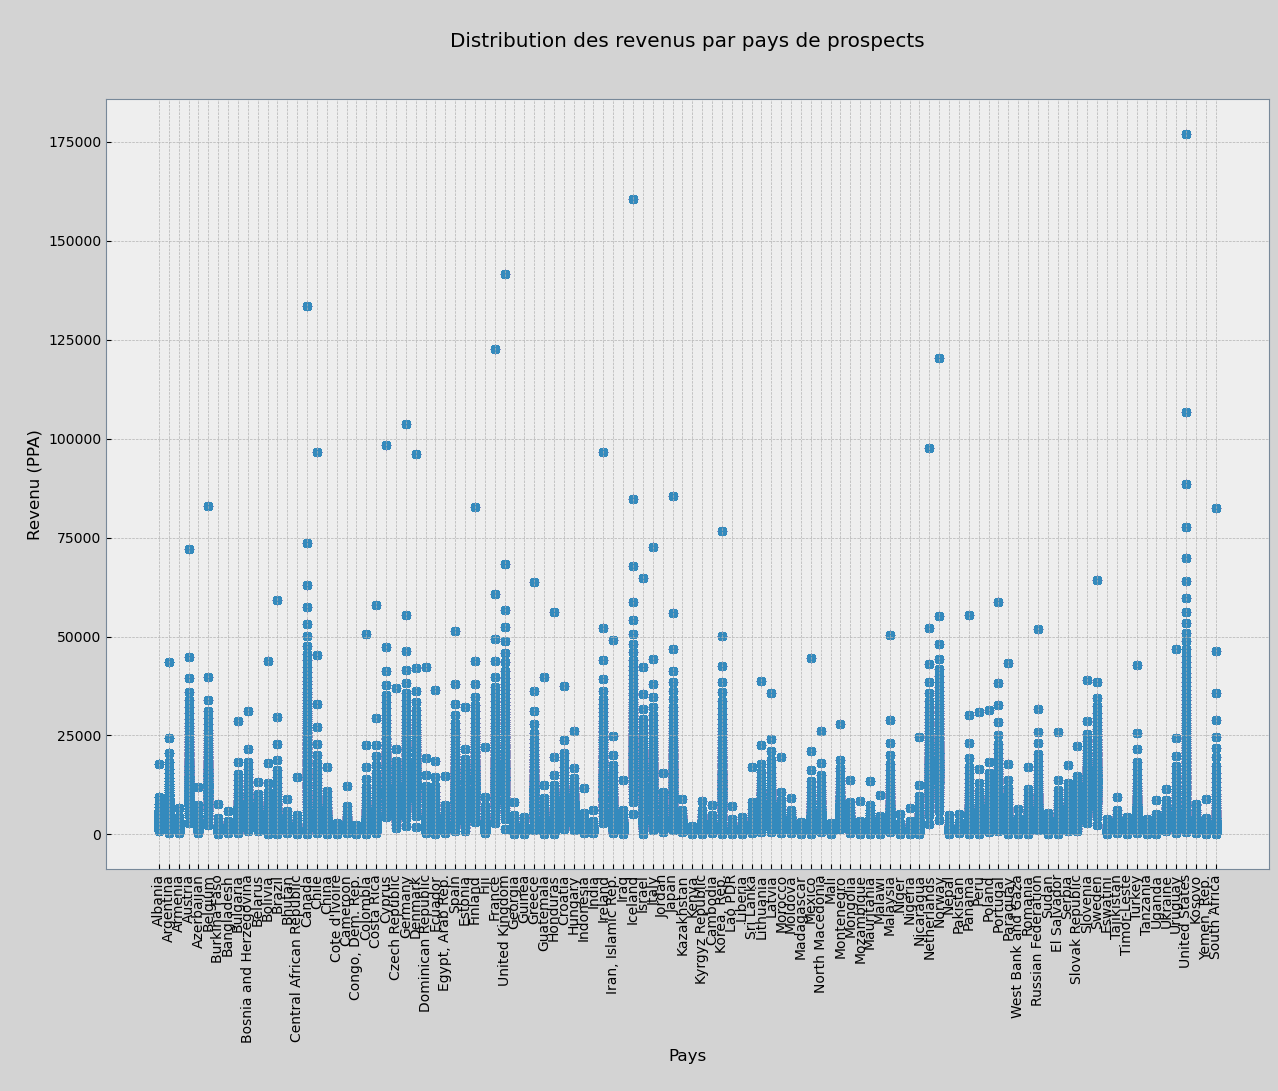

In [160]:
# aperçu de la target
plt.figure(figsize = (15, 10))

plt.scatter(model.pays, model.income)

plt.xlabel('Pays\n')
plt.ylabel('\nRevenu (PPA)')
plt.xticks(rotation = 90)
plt.title('\nDistribution des revenus par pays de prospects\n\n')
plt.show()

##### [**4.1 ANOVA**](#table-des-matières)  
  
Nous étudions les potentiels effets du facteur 'code' (d'un pays donc du lieu) sur le revenu des individus. Il s'agit de tester l'influence d'une variable qualitative sur une variable quantitative => utilisation du test ANOVA à un facteur.  
Échantillon de grande taille => inutile de traiter les éventuels outliers dont les effets seraient littéralement "noyés dans la masse".  
  
**Etapes:**  
- Représentation graphique des deux variables;  : utilisation du nom usuel des pays pour lecture;
- Déroulement du test: utilisation des codes de pays pour diminuer les coûts.  
  
**o Etape 1/2: représentation graphique**

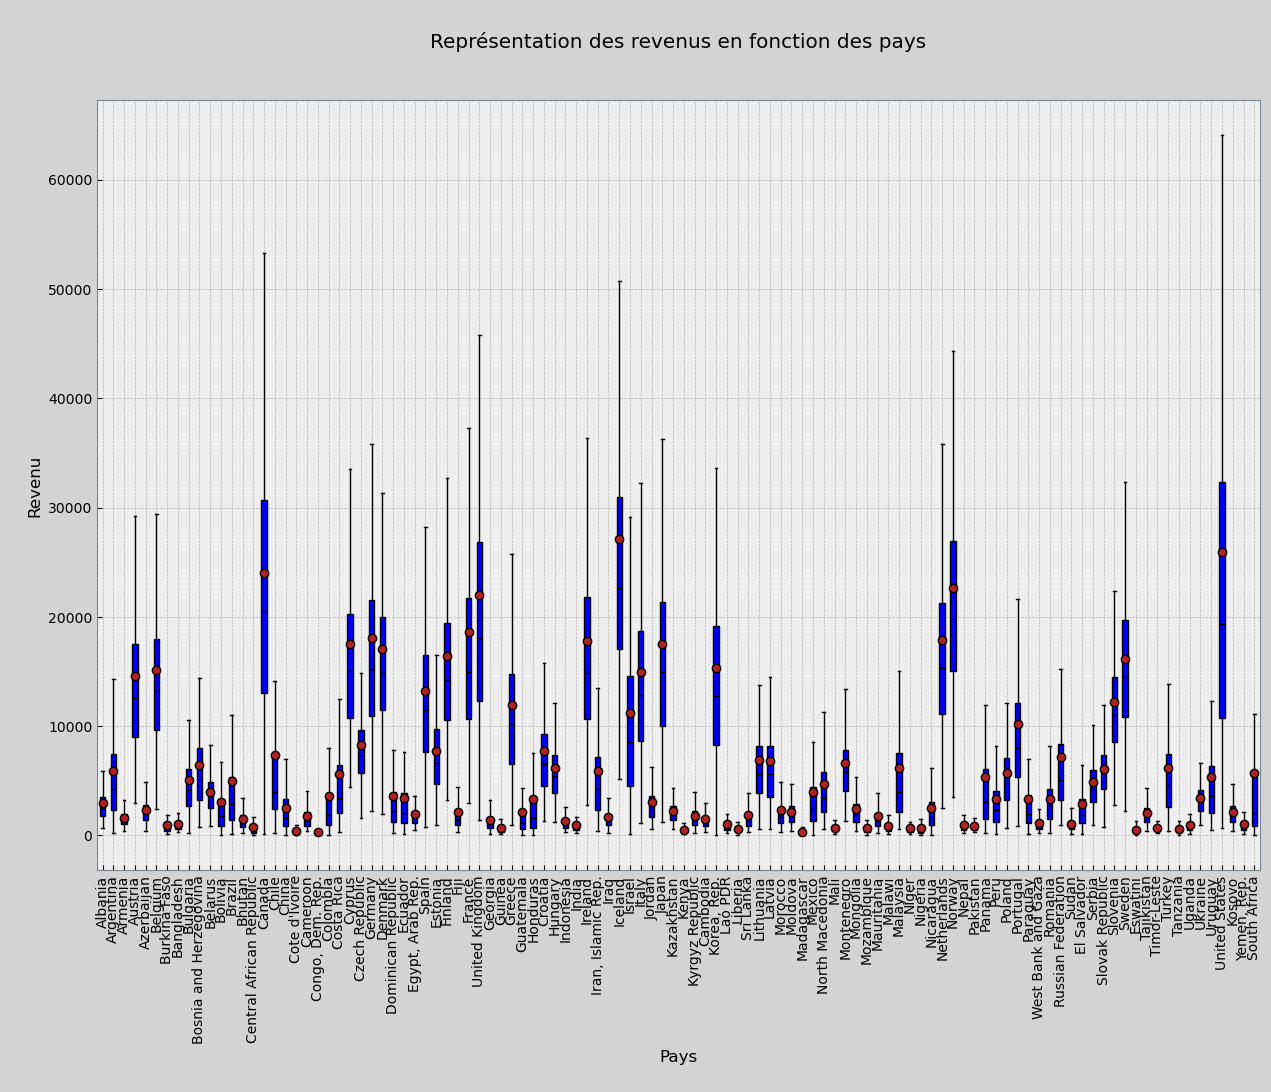

In [161]:
# représentation graphique de 'income' en fonction des modalités de 'pays'
X = 'pays'
Y = 'income'

modalite = model[X].unique()
groupe = []

for m in modalite:
    groupe.append(model[model[X] == m][Y])

medianprops = {'color':"black"}
meanprops = {
            'marker':'o',
            'markeredgecolor':'black',
            'markerfacecolor':'firebrick'
            }
plt.figure(figsize = (15, 10))

plt.boxplot(
    groupe,
    labels = modalite,
    showfliers = False,
    medianprops = medianprops,
    patch_artist = True,
    showmeans = True,
    meanprops = meanprops)
    
plt.title("\nReprésentation des revenus en fonction des pays\n\n")
plt.xlabel('Pays\n')
plt.ylabel('\nRevenu')
plt.xticks(rotation = 90)
plt.show()

Les pays sont classés par ordre alphabétique.  
La représentation graphique fait ressortir 3 profils de pays:  
- ceux dont la distribution des revenus est faiblement étendue et très basse;  
- les distributions moyennes de revenus dont l'étendu est compris dans [10000, 15000[ ppa;  
- l'étendu de la distribution dépassant les 25000 ppa dont les maximums sont dans le voisinage ou dépasse les 30 000.

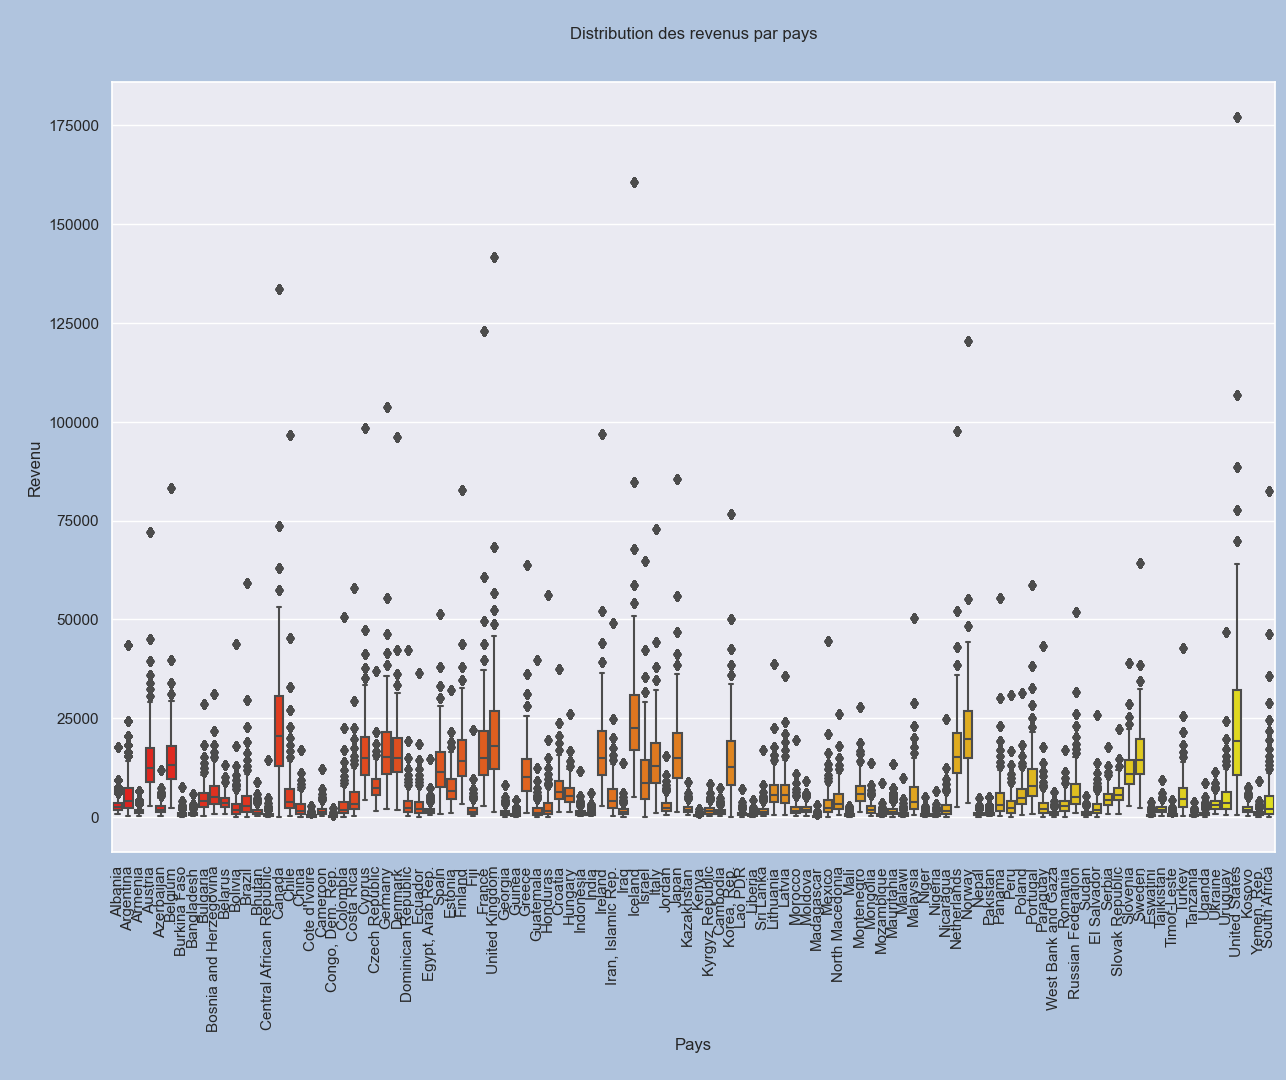

In [162]:
# représentation des revenus par pays
sns.set()
sns.set(rc = {'figure.facecolor':'lightsteelblue'})
plt.figure(figsize = (15, 10))

ax = sns.boxplot(x = 'pays', y = 'income', data = model, palette = "autumn")

plt.xlabel('Pays\n')
plt.ylabel('\nRevenu')
plt.xticks(rotation = 90)
plt.title('\nDistribution des revenus par pays\n\n')
plt.show()

Cette représentation permet une mise en évidence les outliers par pays. Si les valeurs des étendues ne sont plus valables, la première description des profils n'est pas remit en question. Nous avons bien 3 types de distributions délimitées par leur étendue (relative) et la variance totale des revenus par pays.  
Nous passons au test ANOVA afin de mesurer l'influence du lieu sur les revenus.

**o Etape 2/2: ANOVA**  
  
**Le cadre:**  
Nous posons les hypothèses de test:  
- H0: le pays n'a pas d'influence sur les revenus <=> égalité des variances entre pays;  
- H1: les revenus sont influencés par lieu géographique <=> inégalités des variances;  
- Choix du risque d'erreur standard: 5%.  
  
**Le déroulement:**  
- Statistique de Fisher: proportionnelle au rapport $\frac{variance_{expliquée}}{variance_{résiduelle}}$;  
- Condition de rejet de H0: p_value du test < 5%.

In [163]:
# initiation et résultats de test
aov = ols('income~code', data = model).fit()
aov_sumup = sm.stats.anova_lm(aov, typ = 2)
aov_sumup

,sum_sq,df,F,PR(>F)
code,4.503843e+13,107.0,9925.295907,0.0
Residual,5.049459e+13,1190663.0,NaN,NaN


In [165]:
sm.stats.anova_lm(aov, typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
code,107.0,4.503843e+13,4.209199e+11,9925.295907,0.0
Residual,1190663.0,5.049459e+13,4.240880e+07,NaN,NaN


Dans ce récapitulatif, la statistique de test F est exprimée dans la valeur de F-statistic, la Prob constitue la p_value du test de Fisher.  
La p-value est très rarement exact, nous devons avoir un problème de configuration mais cette valeur reste néanmoins pour estimer: p-value << 0.05 => l'hypothèse H0 est rejetée: la variance des revenus d'un pays à l'autre est différente => la pays d'un individu a une influence sur son revenu.  
  
Une autre information importante à considérer est le R² à 47% qui permet de traduire le degré d'influence du lieu. Dans ce cadre d'étude, le pays d'un individu explique moins de 50% son revenu => Nous devons tester l'effet d'autres facteurs afin de pouvoir augmenter le niveau de compréhension des revenus.

#### [**4.2 Régression linéaire**](#table-des-matières)  
  
Nous voulons expliquer les revenus à l'aide de plusieurs facteurs quantitatifs, l'utilisation d'une régression linéaire est donc valable. Elle va se faire de deux manières différentes selon les variables explicatives en jeu. Chacune de ses applications est faite en deux étapes: l'une prend en variable exogène, les revenus et la deuxième considère son logarithme.  
Les deux versions sont exécutées en même temps afin de faciliter les comparaisons.

In [166]:
bdd_20qt.head()

,code,pays,gini,quantile,income
0,ALB,Albania,30.46,1,728.89795
1,ALB,Albania,30.46,1,916.66235
2,ALB,Albania,30.46,1,1010.91600
3,ALB,Albania,30.46,1,1086.90780
4,ALB,Albania,30.46,1,1132.69970


In [167]:
revenu_moy = bdd_20qt.groupby('code').income.mean()
bdd_20qt.set_index('code', inplace = True)

In [168]:
bdd_20qt['revenu_moy'] = revenu_moy

In [169]:
bdd_20qt['log_income'] = np.log(bdd_20qt.income)
bdd_20qt['log_revenu'] = np.log(bdd_20qt.revenu_moy)

##### **4.2.1 1ère étape: deux variables explicatives**  
  
**Le contexte:**  
- Variables explicatives: revenu moyen + indice de Gini;  
- Variable à expliquer: les revenus ou le logarithme des revenus.  
  
**La nomenclature:**  
Les variables correspondant à une "version" logarithmique sont indexées par "_ln".  
  
**Les étapes:**  
- Aperçu graphique des targets et ses features;  
- Applications de la régression linéaire aux données et performance;  
- Phase de test: validité et observations.

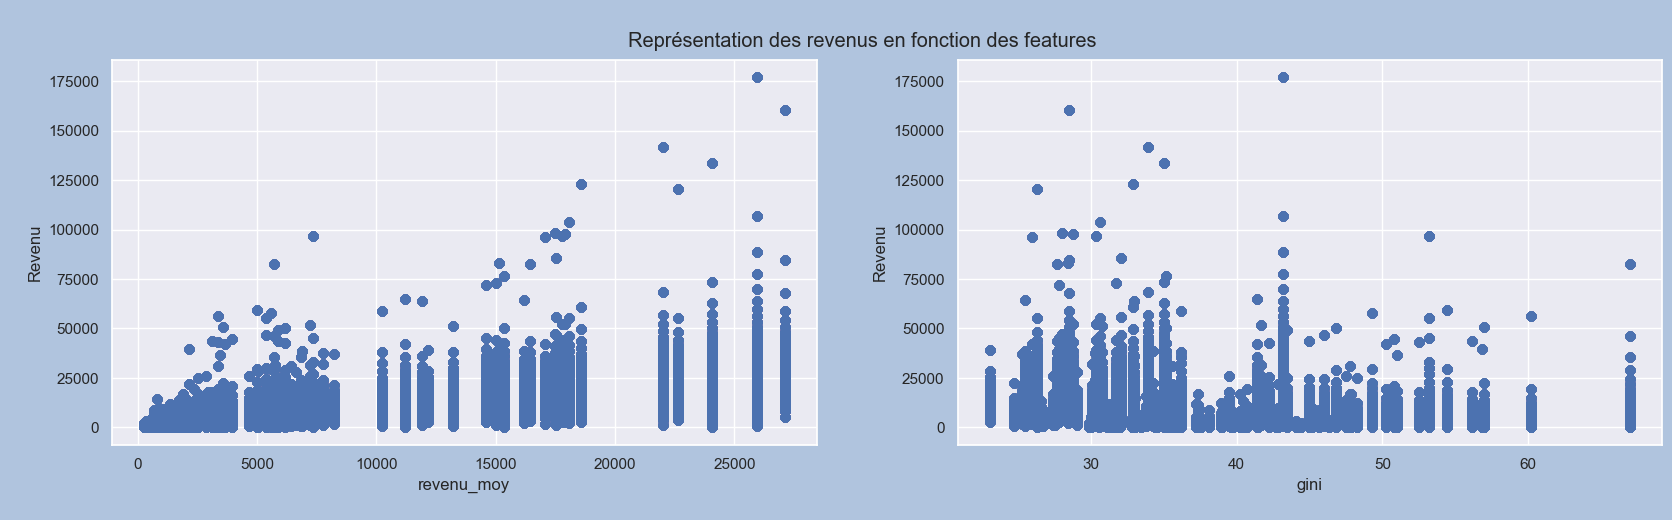

In [170]:
# aperçu graphique
plt.figure(figsize = (20, 5))

features = ['revenu_moy', 'gini']
target = model['income']

for i, ft in enumerate(features):
    plt.subplot(1, len(features) , i + 1)
    x = model[ft]
    y = target
    plt.scatter(x, y, marker = 'o')
    
    plt.xlabel('{}\n'.format(ft))
    plt.ylabel('\nRevenu')

plt.suptitle('\nReprésentation des revenus en fonction des features\n\n')
plt.show()

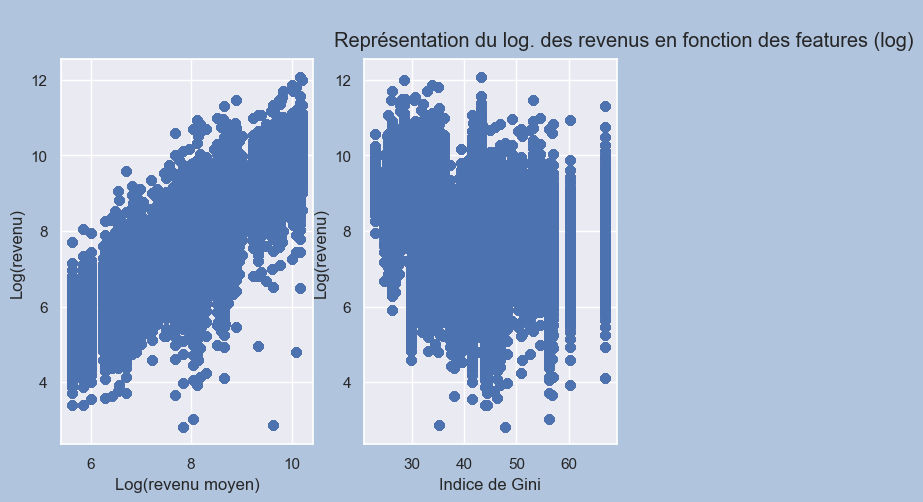

In [171]:
# aperçu graphique en considérant le log des revenus
plt.figure(figsize = (15, 5))

x_ln = np.log(model.revenu_moy)
target = np.log(model.income)

plt.subplot(1, len('gini'), 1)
x = x_ln
y = target
plt.scatter(x_ln, y, marker = 'o')
plt.xlabel('Log(revenu moyen)')
plt.ylabel('Log(revenu)')

plt.subplot(1, len('gini') , 2)
x = model.gini
y = target
plt.scatter(x, y, marker = 'o')
plt.xlabel('Indice de Gini')
plt.ylabel('Log(revenu)')

plt.suptitle('\nReprésentation du log. des revenus en fonction des features (log)\n\n')
plt.show()

La représentation graphique mettant en jeu les logarithmes semble davantage présenter une relation linéaire que les variables prises telles quelles.  
=> Nous nous attendons à ce que le modèle de regression linéaire construit sur le logarithme des revenus soit plus performant.

**o Etape 2/4: Les modèles**  
  
Nous rappelons que l'application de la régression linéaire se fait en deux versions: en nature et en logarithme des revenus.  
  
Nous posons:  
- H0: le niveau d'influence des features n'est pas assez significatif pour expliquer les revenus;  
- H1: les features ont une influence sur le revenus des individus.  
  
- Statistique de test: F;  
- Risque d'erreur standard: 5%.  
  
- Condition de rejet de H0: p_value du test < risque d'erreur.

In [172]:
# mise en régression des données
rlm_model = smf.ols('income ~ revenu_moy+gini', data = model).fit()
print(rlm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                 5.311e+05
Date:                Wed, 31 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:30:27   Log-Likelihood:            -1.2146e+07
No. Observations:             1190771   AIC:                         2.429e+07
Df Residuals:                 1190768   BIC:                         2.429e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.528e-10     28.221   2.67e-11      1.0

- La p-value de la régression linéaire < 0.05.  
=> H0 est rejetée => Les revenus moyens et l'indice de Gini ont une influence significative sur le revenu. Ce résultat est intuitif puisque l'indice de Gini est une caractéristique d'un pays or nous avons vu que le lieu avait une incidence sur les revenus.
- Le coefficient de détermination R² est à 47%. Il est inférieur à celui du test.  
=> Ce modèle explique moins de variance des revenus que le modèle ANOVA ce qui est contre-intuitif => les revenus moyens ne permettent pas d'expliquer les revenus et ont un effet de "lissage" des données;  
- la p_value de l'indice de Gini est supérieure à 5%, ce qui rend ce feature non significatif dans le cadre de test alors que celle du revenu moyen est 0.  
Les résultats de cette analyse se contre-disent.  
=> Les résultats ne sont statistiquement pas significatifs pour pouvoir valider ou rejeter H0.

In [173]:
# préparation des données pour le modle logarithmique
model['log_income'] = np.log(model.income)
model['log_revenu'] = np.log(model.revenu_moy)

In [174]:
# application de la régression
rlm_model_ln = smf.ols('log_income ~ log_revenu+gini', data = bdd_20qt).fit()
print(rlm_model_ln.summary())

                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                 1.471e+04
Date:                Wed, 31 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:30:28   Log-Likelihood:                -11863.
No. Observations:               10899   AIC:                         2.373e+04
Df Residuals:                   10896   BIC:                         2.375e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4632      0.065      7.105      0.0

**o Etape 3/4: performance de l'approche**  
  
- Equation de régression: revenu = (0.99 * log_revenu) - (0.01 * gini) + 0.45
- La p_value du test est dans ses normes;  
- Le pourcentage de variance exprimée à travers R² est à 70% => cette approche est bien plus performante pour expliquer l'influence des features sur les revenus;  
- Les p-values des features sont nulles => des changements dans les features sont liés aux changements de la target => facteurs significatifs.  
- Le coefficient de détermination de Gini est négatif => ce feature ne favorise pas la valeur de la target.
  
=> Les p_values (du test et des features) nous permettent de rejeter H0 et de conclure à une influence significative des features sur le log des revenus.
=> D'autres facteurs n'ont pas été pris en comptes. Parmi eux, il y a les autres paramètres de l'étude ainsi que des variables inconnus dans ce cadre. La variance expliquée par l'ensemble de ces facteurs est de 30%.

**o Etape 4/4: validation des résultats**  
  
Pour pouvoir assurer la validité des résultats précédents, il nous faut vérifier certaines hypothèses concernant le modèle:  
- a: linéarité entre la target et ses features;  
- b: indépendance des résidus;  
- c: homoscédasticité des résidus;  
- d: normalité des résidus;  
- e: absence de colinéarité entre les features.  
  
**o Etape 4/4a: linéarité**  
  
- But: vérifier que l'application d'une régression linéaire dans ce contexte soit appropriée.  
- Procédé: confronter graphiquement les résidus aux features.

In [175]:
# rappel des résultats de la régression linéaire
print(rlm_model_ln.summary())

                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                 1.471e+04
Date:                Wed, 31 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:30:28   Log-Likelihood:                -11863.
No. Observations:               10899   AIC:                         2.373e+04
Df Residuals:                   10896   BIC:                         2.375e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4632      0.065      7.105      0.0

c:\Users\Dar_ia\miniconda3\envs\data-py3.10\lib\site-packages\statsmodels\graphics\regressionplots.py:430: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = abline_plot(0, fitted_line.params[0], color='k', ax=ax)


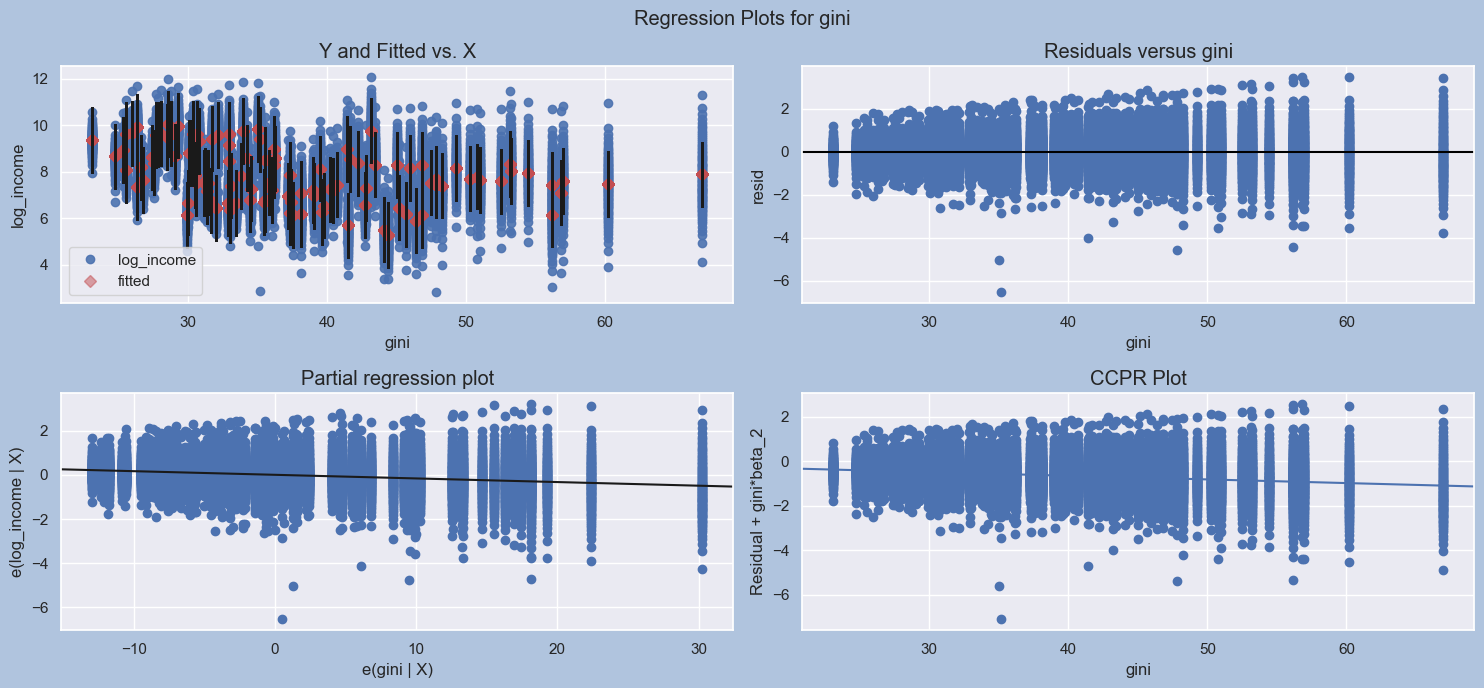

In [176]:
# linéarité entre la target et le feature 'gini'
fig = plt.figure(figsize = (15, 7))
fig = sm.graphics.plot_regress_exog(rlm_model_ln, 'gini', fig = fig)

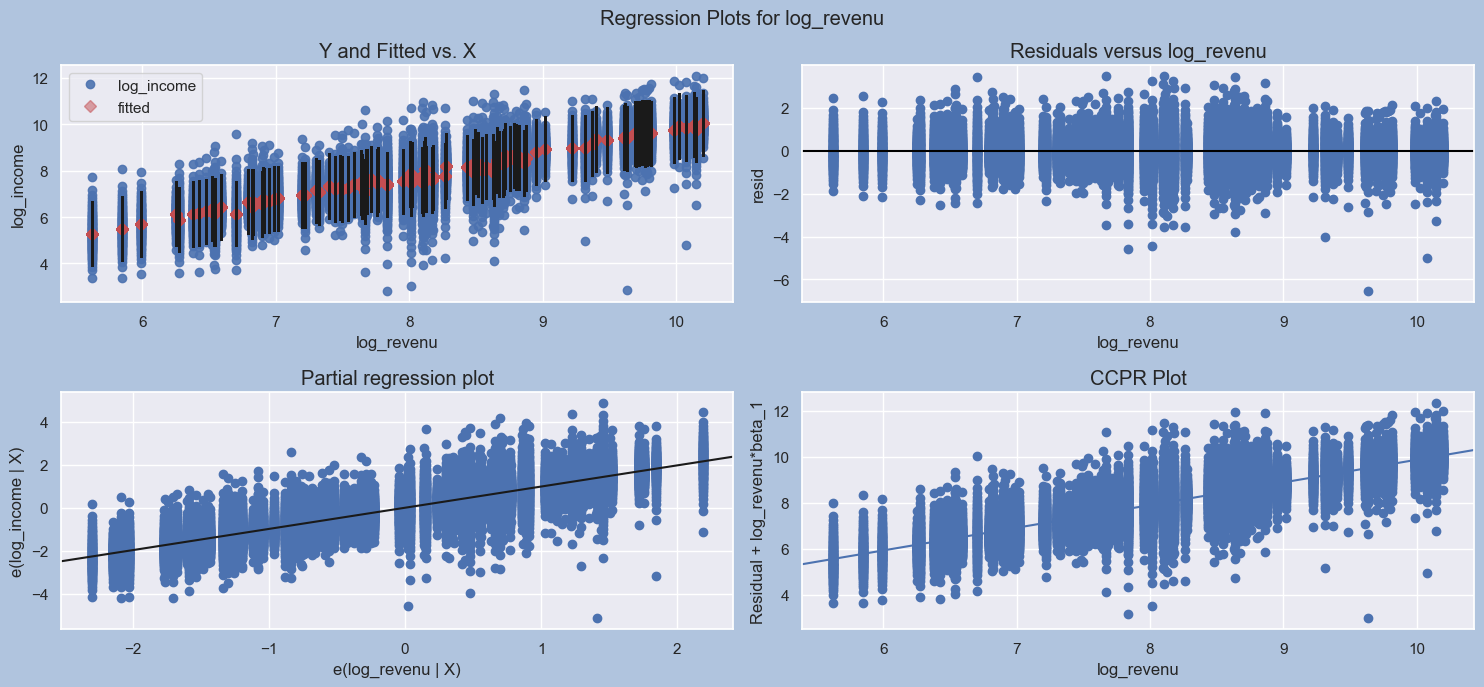

In [177]:
# linéarité entre la target et le feature 'log_revenu'
fig = plt.figure(figsize = (15, 7))
fig = sm.graphics.plot_regress_exog(rlm_model_ln, 'log_revenu', fig = fig)

Pour les deux features, la forme des scatterplots n'est pas celle d'une nuage de résidus : elle présente un motif symétrique, horizontale mais n'est pas ronde.  
=> Dans le cadre de cette étude, la seule façon de remédier à ce problème est de rajouter une autre variable explicative.  
=> cf. 4.2.2 (à la suite).  
  
**o Etape 4/4b: indépendance**  
  
- But: vérifier que les résidus ne soient pas corrélés entre eux.
- Procédé: test de Durbin-Watson.  
  
Nous posons:  
- H0: les résidus ne sont pas corrélés;  
- H1: les résidus sont corrélés entre eux.  
  
- Statistique de test: d;
- Risque d'erreur standard.  
  
- Condition de rejet:  
    -- d = 2 => pas de corrélation;  
    -- d < 2 => corrélation positive;  
    -- d > 2 => corrélation négative.

In [178]:
# test de Durbin-Watson
d = durbin_watson(rlm_model_ln.resid)
print('Statistique de d =', round(d, 2))

Statistique de d = 0.39


La statistique de test d de Durbin-Watson est inférieure à 2 => H0 est rejetée => Il existe une corrélation entre les résidus.  
Pour y remédier, il nous faudrait, une fois encore, rajouter un feature au modèle.  
  
**o Etape 4/4c: égalité des variances**  
  
- But: permet de metre en avant l'existence de valeurs aberrantes ou remarquables.  
- Procédé: test de Breusch-Pagan.  
  
Nous posons:
- H0: les variances sont homogènes;  
- Ha: les variances sont hétérogènes.  
  
- Statistique de test: L.
- Risque d'erreur standard.  
  
- Condition de rejet de H0: p_value du test < 5%

In [179]:
# préparation du test
names = ['Statistique de test L', 'p_value', 'f_value', 'f p_value']

In [180]:
test_BP = sms.het_breuschpagan(rlm_model_ln.resid, rlm_model_ln.model.exog)
list(zip(names, test_BP))

[('Statistique de test L', 675.1327331993576),
 ('p_value', 2.4933871079514296e-147),
 ('f_value', 359.7584978840497),
 ('f p_value', 5.02504776076697e-152)]

La p_value du test BP ne possède pas de valeurs assez significatives => nous ne pouvons pas conclure sur la nature des variances des résidus.  
Nous ne cherchons pas à rétablir les paramètres puisque le résultat importe peu. En effet, deux des hypothèses ne sont pas vérifiées. Dans ce contexte, le seul moyen de corriger ces problèmes est de rajouter une autre variable.  
=> Nous cessons la vérification des tests puisque nous avons suffisamment d'arguments pour critiquer le modèle principal.

In [181]:
influence = rlm_model_ln.get_influence()
residu = rlm_model_ln.resid
levier = influence.hat_matrix_diag

La variance totale expliquée par le modèle de régression linéaire à deux facteurs est significatif mais il présente trop d'irrégularités notamment au niveau du comportement de ses résidus. Puisque nous ne pouvons pas modifier la target et les features déjà abordées, nous devons ajouter une autre variable explicative pour l'améliorer.

##### [**4.2.2 2ème étape: test à trois facteurs**](#table-des-matières)  
  
**Le contexte**  
- Features: revenu moyen, indice de Gini et quantile;  
- Target: revenus et log(revenus) . 
  
**Les données:**  
- Les revenus et le log des revenus sont toutes deux considérées dans les modèles;  
- La nomenclature précédente (_ln) est identique.  
  
**Les étapes:**  
- Aperçu graphiques;  
- Régression linéaire des données et performances;  
- Validité et observations.

In [182]:
model.head(2)

,code,pays,gini,quantile_p,revenu_moy,income,log_income,log_revenu
0,ALB,Albania,30.46,1,2966.336038,728.89795,6.591534,7.995083
1,ALB,Albania,30.46,1,2966.336038,916.66235,6.820739,7.995083


In [183]:
# petite prépa. qui aurait allégée bien des lignes
model['log_income'] = np.log(model.income)
model['log_revenu'] = np.log(model.revenu_moy)

**o Etape 1/3: aperçus graphiques**

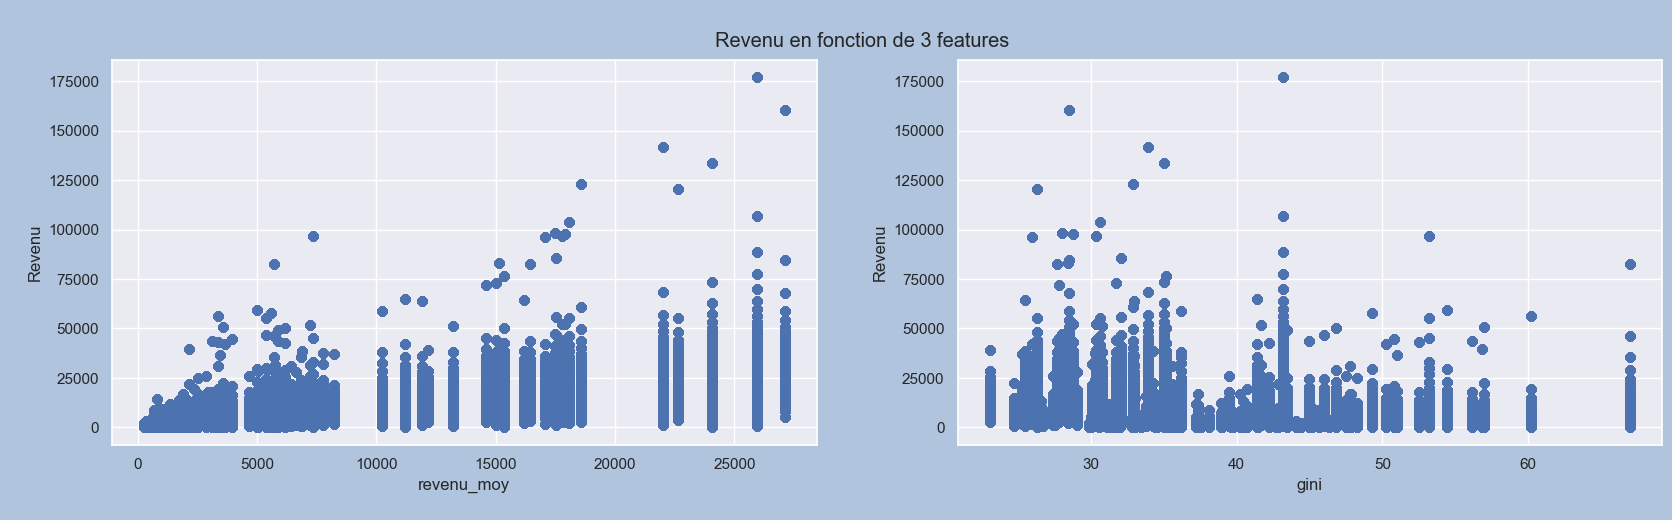

In [184]:
# data visualisation: rappek
plt.figure(figsize = (20, 5))

features = ['revenu_moy', 'gini']
target = model['income']

for i, f in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = model[f]
    y = target
    plt.scatter(x, y, marker ='o')
    
    plt.xlabel('{}\n'.format(f))
    plt.ylabel('\nRevenu')

plt.suptitle('\nRevenu en fonction de 3 features\n\n')
plt.show()

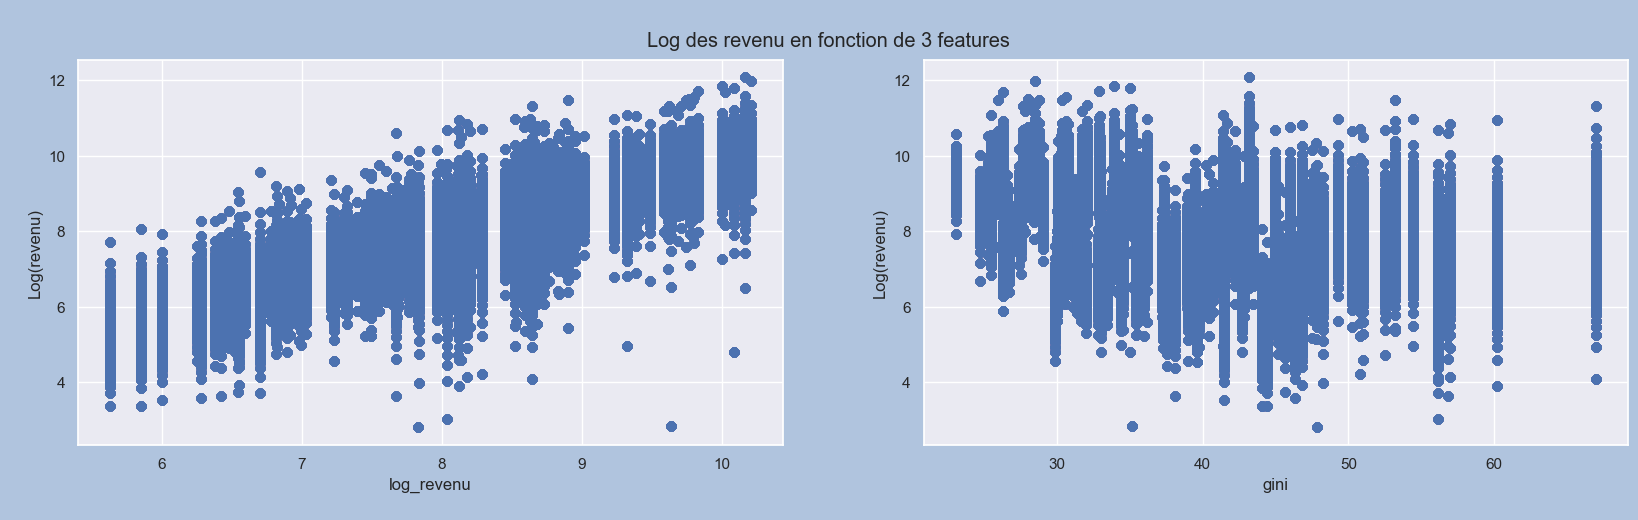

In [185]:
# data visualisation: rappel
plt.figure(figsize = (20, 5))

features = ['log_revenu', 'gini']
target = model['log_income']

for i, f in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = model[f]
    y = target
    plt.scatter(x, y, marker ='o')
    
    plt.xlabel('{}\n'.format(f))
    plt.ylabel('\nLog(revenu)')

plt.suptitle('\nLog des revenu en fonction de 3 features\n\n')
plt.show()

In [186]:
# pourquoi faire simple quand on peut compliquer
df = model[['income', 'log_income', 'gini']]
df = df.drop_duplicates('gini')

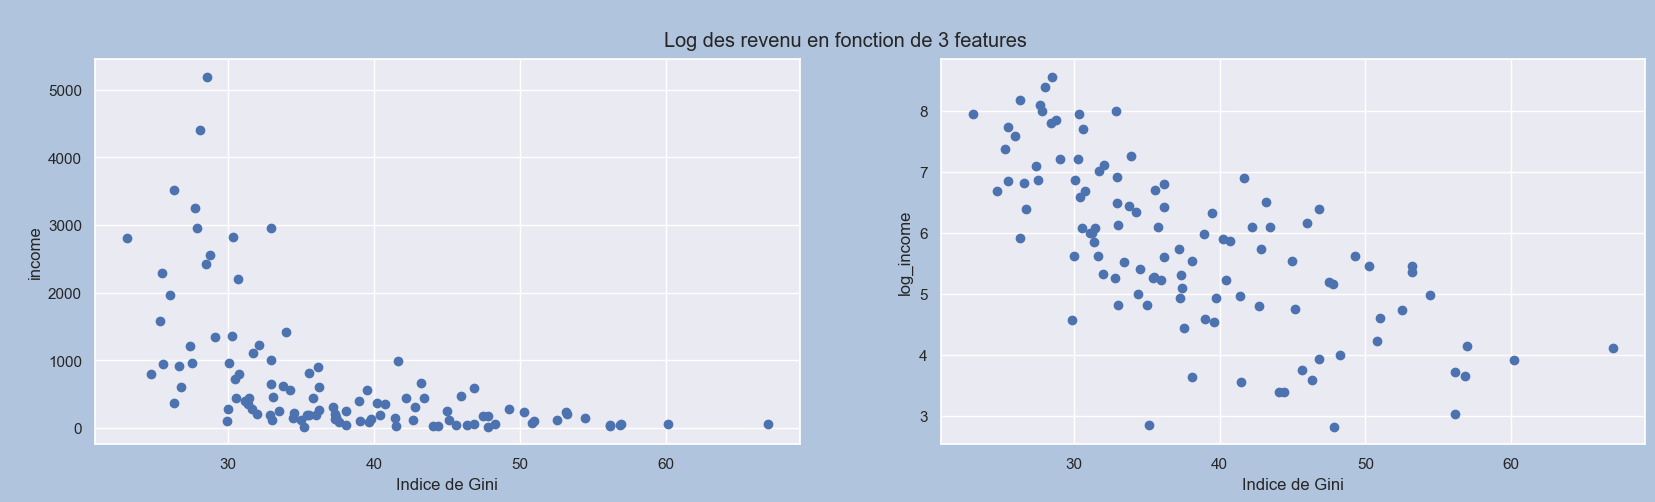

In [187]:
# data visualisation: rappel
plt.figure(figsize = (20, 5))

target = ['income', 'log_income']

for i, t in enumerate(target):
    plt.subplot(1, len(features) , i+1)
    x = df['gini']
    y = df[t]
    plt.scatter(x, y, marker ='o')
    
    plt.xlabel('Indice de Gini')
    plt.ylabel('\n{}'.format(t))

plt.suptitle('\nLog des revenu en fonction de 3 features\n\n')
plt.show()

Le premier nuage de points retrace le motif d'une fonction logarithmique tandis que le deuxième semble présente une relation linéaire avec le log. des revenus.  
=> Une fois de plus, nous nous attendons à ce que le modèle reposant sur les log. explique la variance des revenus de façon plus performante que le "standard".  
  
**o Etape 2/4: Les modèles**  
  
Posons le cadre:  
- H0: le niveau d'influence des features n'est pas assez significatif pour expliquer les revenus;  
- H1: les features ont une influence sur le revenus des individus.  
  
- Statistique de test: F;  
- Risque d'erreur standard: 5%.  
  
- Condition de rejet de H0: p_value du test < risque d'erreur.

In [189]:
# mise en régression des données
regLin_3ft = smf.ols('income ~ revenu_moy+gini+quantile_p', data = model).fit()
print(regLin_3ft.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.508
Model:                            OLS   Adj. R-squared:                  0.508
Method:                 Least Squares   F-statistic:                 4.097e+05
Date:                Wed, 31 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:32:54   Log-Likelihood:            -1.2104e+07
No. Observations:             1190771   AIC:                         2.421e+07
Df Residuals:                 1190767   BIC:                         2.421e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3030.1648     29.075   -104.217      0.0

- La p_value du test est inférieure à 5%.  
=> H0 est rejetée et les features sont considérées come ayant une influence significatives sur les revenus.  
- La valeur de R² nous informe que ce modèle n'explique que la moitié de la variance des revenus. => L'ajout des quantile_p ne permet que d'augmenter de 3 points la part de variance expliquée.  
- La p_value de l'indice de Gini permet de conclure que la variable 'gini' n'a pas de sens statistique dans ce modèle. 

In [190]:
# mise en régression des données _ln
regLin_3ft_ln = smf.ols('log_income ~ log_revenu+gini+quantile_p', data = model).fit()
print(regLin_3ft_ln.summary())

                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                 1.177e+06
Date:                Wed, 31 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:33:19   Log-Likelihood:            -1.1978e+06
No. Observations:             1190771   AIC:                         2.396e+06
Df Residuals:                 1190767   BIC:                         2.396e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0666      0.006    -11.579      0.0

**o Etape 3/4: performance de l'approche**  

- La p_value du test valide Ha => les 3 features ont une influence significative sur le log. des revenus.  
- Ce  modèle explique près de 75% de la variance des revenus, ce qu ien fait le modèle le plus performant. La part de variance inexpliquée étant donc de 25%.  
- Les p_values des paramètres sont nulles. => signification statistique des paramètres est affirmée.  
- Equation de régression: log_income = log_revenu - 0.02 Gini + 0.05 Quantile - 0.07  
- Ici aussi, nous notons le coefficient négatif de l'indice de Gini => un pays à forte inégalité réduit la probabilité d'avoir un haut revenu.

**o Etape 4/4: validation des résultats**  
Pour pouvoir assurer la validité des résultats précédents, il nous faut vérifier certaines hypothèses concernant le modèle:  
- a: linéarité entre la target et ses features;  
- b: indépendance des résidus;  
- c: homoscédasticité des résidus;  
- d: normalité des résidus;  
- e: absence de colinéarité entre les features.  
  
**o Etape 4/4a: linéarité**  
  
- But: vérifier que l'application d'une régression linéaire dans ce contexte soit appropriée.  
- Procédé: les relations linéaires ont déjà été mises en évidence en début de partie.

**o Etape 4/4b: indépendance**  
  
- But: vérifier que les résidus ne soient pas corrélés entre eux afin de s'assurer de l'intégrité des estimateurs du modèle..
- Procédé: test de Durbin-Watson.  
  
Nous posons:  
- H0: les résidus ne sont pas corrélés;  
- H1: les résidus sont corrélés entre eux.  
  
- Statistique de test: d;
- Risque d'erreur standard.  
  
- Condition de rejet:  
    -- d = 2 => pas de corrélation;  
    -- d < 2 => corrélation positive;  
    -- d > 2 => corrélation négative.

In [191]:
# test de Durbin-Watson
d = durbin_watson(regLin_3ft_ln.resid)
print('Statistique de d =', round(d, 2))

Statistique de d = 0.15


D << 2 => à ce stade, il faudrait soit continuer à rajouter des paramètres soit revoir le choix des features.

**o Etape 4/4c: égalité des variances**  
  
- But: permet de metre en avant l'existence de valeurs aberrantes ou remarquables.  
- Procédé: test de Breusch-Pagan.  
  
Nous posons:
- H0: les variances sont homogènes;  
- Ha: les variances sont hétérogènes.  
  
- Statistique de test: L.
- Risque d'erreur standard.  
  
- Condition de rejet de H0: p_value du test < 5%

In [192]:
# préparation du test
names = ['Statistique de test L', 'p_value', 'f_value', 'f p_value']

In [193]:
test_BP = sms.het_breuschpagan(regLin_3ft_ln.resid, regLin_3ft_ln.model.exog)
list(zip(names, test_BP))

[('Statistique de test L', 69257.81173962339),
 ('p_value', 0.0),
 ('f_value', 24511.501536502485),
 ('f p_value', 0.0)]

**o Etape 4/4c: normalité**  
  
But : vérifier la qualité des intervalle de confiance et de test.  
Procédé: QQ-plot.

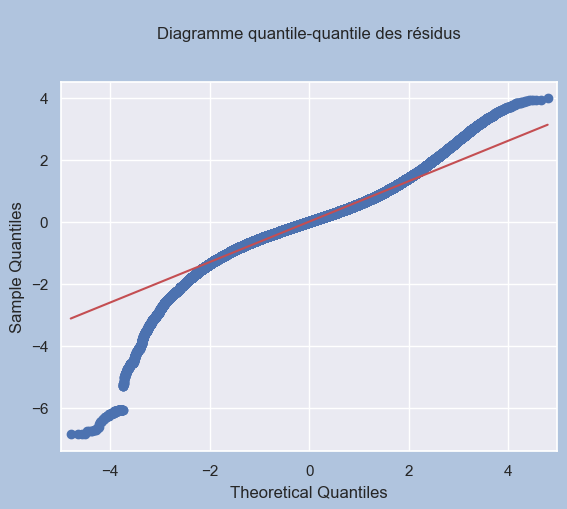

In [194]:
# q-q plot de cluster A
sm.qqplot(regLin_3ft_ln.resid, line = 'r')
plt.title('\nDiagramme quantile-quantile des résidus\n\n')
plt.show()

La distribution des résidus suit bien une loi normale. Forte présence de outliers.  
  
**o Etape 4/4c: featuring**  
  
But: vérifier que le degré de colinéarité des features ne soit pas significatif rendant le modèle instable.  
Procédé: scatterplot.

In [195]:
valeur_regLim = regLin_3ft_ln.fittedvalues
residu = regLin_3ft_ln.resid

c:\Users\Dar_ia\miniconda3\envs\data-py3.10\lib\site-packages\statsmodels\graphics\regressionplots.py:430: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fig = abline_plot(0, fitted_line.params[0], color='k', ax=ax)


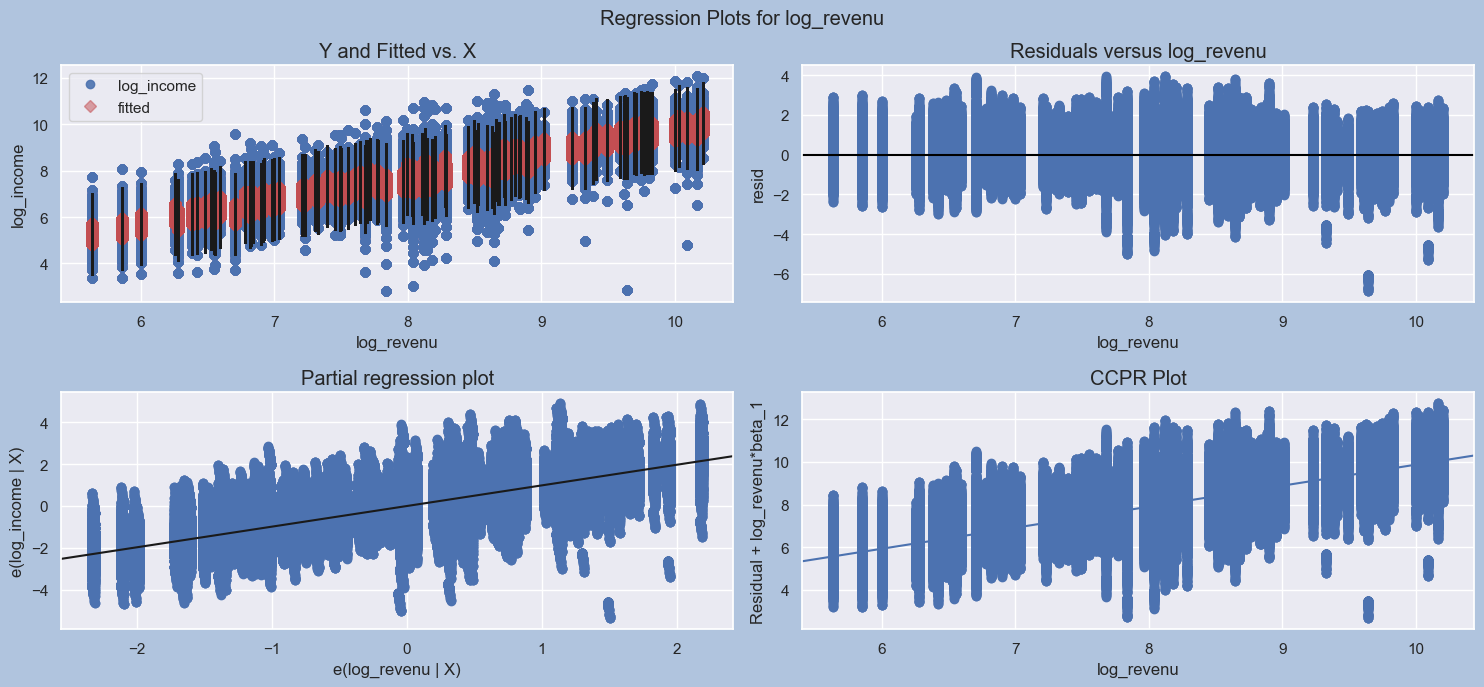

In [196]:
# linéarité entre la target et le feature 'log_revenu'
fig = plt.figure(figsize = (15, 7))
fig = sm.graphics.plot_regress_exog(regLin_3ft_ln, 'log_revenu', fig = fig)

In [199]:
# plot different diagnostic plots
#plt.rcParams["figure.figsize"] = (20,15)
#fig, ax = plt.plot(nrows=2, ncols=2)
'''plt.figure(figsize = (15, 15))
plt.style.use('seaborn')

sns.scatterplot(x = valeur_regLim, y = residu)
plt.axhline(y = 0, color = 'grey', linestyle = 'dashed')
plt.xlabel('Valeurs du modèle\n\n')
plt.ylabel('\nRésidus')
plt.title('\nResiduals vs Fitted Fitted\n\n')
plt.show()'''

"plt.figure(figsize = (15, 15))\nplt.style.use('seaborn')\n\nsns.scatterplot(x = valeur_regLim, y = residu)\nplt.axhline(y = 0, color = 'grey', linestyle = 'dashed')\nplt.xlabel('Valeurs du modèle\n\n')\nplt.ylabel('\nRésidus')\nplt.title('\nResiduals vs Fitted Fitted\n\n')\nplt.show()"

Le modèle de régression linéaire construit à partir des 3 features dans as version logarithmique ne vérifie pas les hypothèses de test, par conséquent, les résultats engendrés ont un risque élevé d'être biaisés. Nous avons donc un modèle qui ne décrit pas correctement les influences des features sur la variable réponse que sont les log. des revenus.  
De plus, la sur-représentation des individus à travers le clonage rend les graphiques statistiquement dénaturées. Par exemple, dans la représentation des résidus en fonction des features, la forme globale correspond à ce que l'on attend d'un scatterplot de résidus mais la texture comme dupliquée rend la représentation statistiquement fausse.

#### **Conclusion**  
  
Pour maximiser la probabilité que les prospects répondent au critère de la banque, considérer les classes de revenus des parents ne suffit pas. Conditions supplémentaires à prendre en considération:  
- Considérer le log des revenus parentaux et non les valeurs absolues;  
- Indice d'égalité bas.